## Setup, Loading Data and CDFs

In [1]:
DATA_NAME = 'spaceNet-full' 
TRANSFORM = 'wavelet-diagonal'
CHANNEL = 'gray'

In [2]:
path_list = DATA_NAME.split("-") + TRANSFORM.split("-")
if CHANNEL:
    path_list.append(CHANNEL)
print(f"Name the notebook:\n{'_'.join(path_list[::-1])}.ipynb")
FULL_DATA_NAME='-'.join(path_list)

Name the notebook:
gray_diagonal_wavelet_full_spaceNet.ipynb


In [3]:
import git
from pathlib import Path
import os

ROOT_DIR = Path(git.Repo('.', search_parent_directories=True).working_tree_dir)
CWD = os.path.join(ROOT_DIR, "results", "case-studies", *path_list)
assert CWD == os.getcwd()

Path(os.path.join(CWD, "CSVs")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "plots")).mkdir(exist_ok=True)
Path(os.path.join(CWD, "cache")).mkdir(exist_ok=True)

GROUP = 'layer' if TRANSFORM.split("-")[0] == 'wavelet' else ('band' if TRANSFORM.split("-")[0] == 'fourier' else 'error')
RERUN = True
SKIP_OPTIMIZE_STEP = False
CWD

'/Users/brandonmarks/Desktop/hierarchical-bayesian-model-validation/results/case-studies/spaceNet/full/wavelet/diagonal/gray'

In [4]:
os.chdir(os.path.join(ROOT_DIR, "utilities"))
from testing import * # If MATLAB is not installed, open utilities and set to False
from plotting import *
os.chdir(CWD)
np.random.seed(0)

In [5]:
group_data_map = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}.pickle'))
group_total_samples = pd.read_pickle(os.path.join(ROOT_DIR, "transformed-data", f'{FULL_DATA_NAME}-size.pickle'))

In [6]:
if 'fourier' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)[::3]
elif 'wavelet' in TRANSFORM:
    GROUPS = np.arange(2, sorted(group_data_map)[-1] + 1)

cdfs_dir = os.path.join(ROOT_DIR, "results", "CDFs")
cdfs_list = sorted([os.path.join(cdfs_dir, i) for i in os.listdir(cdfs_dir)])
all_cdfs = combine_pickles(cdfs_list[0])
for cdf_dir in cdfs_list[:6]: # TODO For quick testing purposes. Currently excluding 20000 CDFs. Use cdfs_list[5:6] to access CDFs/_test
    all_cdfs = all_cdfs | combine_pickles(cdf_dir)
    
# group_data_map = {g : group_data_map[g][::100] for g in GROUPS} # TODO For quick testing purposes
group_total_samples

{2: 13604,
 3: 54416,
 4: 166649,
 5: 574769,
 6: 2125625,
 7: 8502500,
 8: 34010000,
 9: 136040000}

Running 12720 CDFs


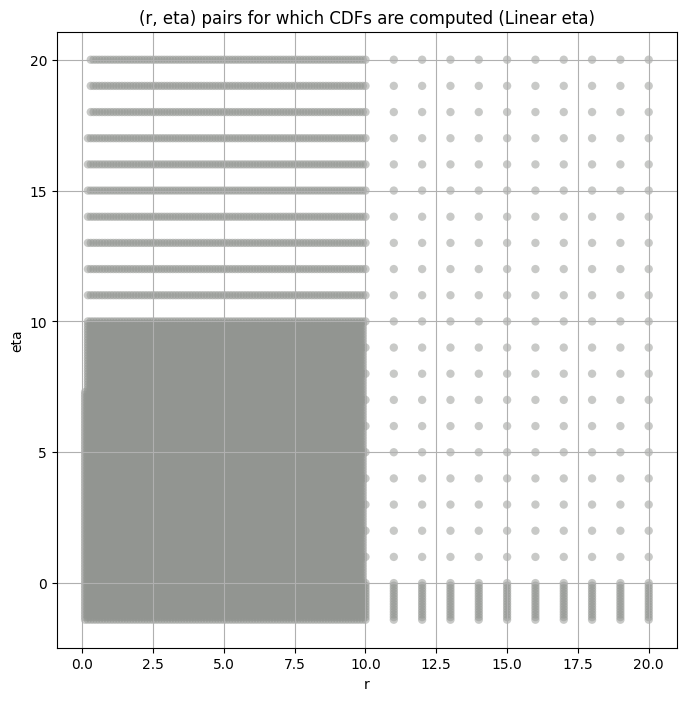

(r,eta),cdf    r  eta  \
0  ((0.1, -1.4), <scipy.interpolate._fitpack2.Int...  0.1 -1.4   
1  ((0.1, -1.3), <scipy.interpolate._fitpack2.Int...  0.1 -1.3   
2  ((0.1, -1.2), <scipy.interpolate._fitpack2.Int...  0.1 -1.2   
3  ((0.1, -1.1), <scipy.interpolate._fitpack2.Int...  0.1 -1.1   
4  ((0.1, -1.0), <scipy.interpolate._fitpack2.Int...  0.1 -1.0   

                                                 cdf      variance  \
0  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.628800e+06   
1  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.991680e+07   
2  <scipy.interpolate._fitpack2.InterpolatedUniva...  2.395008e+08   
3  <scipy.interpolate._fitpack2.InterpolatedUniva...  1.037837e+09   
4  <scipy.interpolate._fitpack2.InterpolatedUniva...  3.632429e+09   

        kurtosis  
0  554265.000000  
1   96192.272727  
2   29390.000000  
3   11997.692308  
4    5874.890110

In [7]:
warnings.filterwarnings('ignore', category=RuntimeWarning)

all_cdfs_df = create_kurt_var_ksstat_df(all_cdfs)
fine_cdfs_df = all_cdfs_df.copy()
all_cdfs_df = all_cdfs_df[(np.round(all_cdfs_df['r'], 1) == all_cdfs_df['r']) & (np.round(all_cdfs_df['eta'], 1) == all_cdfs_df['eta'])]
all_cdfs_df = all_cdfs_df[~all_cdfs_df['kurtosis'].isna()]
all_cdfs_df = all_cdfs_df[~(all_cdfs_df['kurtosis'] == np.inf)]
all_cdfs_df = all_cdfs_df.reset_index(drop=True)
all_cdfs = {x[0] : x[1] for x in all_cdfs_df["(r,eta),cdf"]}
                                             
var_values_dict = dict()
kurt_values_dict = dict()
master_df = pd.DataFrame(columns=[GROUP]).set_index(GROUP)
temp_cdf = all_cdfs_df
print(f"Running {all_cdfs_df.shape[0]} CDFs")
create_scatter_plot(all_cdfs_df);

all_cdfs_df.head()

## Bootstrapping the Variance and Kurtosis

In [8]:
n_bootstrap = int(1e5) # TODO For quick testing purposes
bootstrap_size = int(1e4) # TODO For quick testing purposes
ci = 0.99

In [9]:
bootstrap_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))
master_df_var_kurt_path = Path(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

if RERUN or not master_df_var_kurt_path.exists(): # TODO For quick testing purposes
    for group in GROUPS:
        print(f'{GROUP.capitalize()} {group}')
        obs_var, var_lower, var_upper, var_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                n_bootstrap=n_bootstrap, 
                                                                                bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                metric= np.var, 
                                                                                ci=ci)
        obs_kurt, kurt_lower, kurt_upper, kurt_values_dict[group] = bootstrap_metric(group_data_map[group], 
                                                                                    n_bootstrap=n_bootstrap, 
                                                                                    bootstrap_size=min(group_data_map[group].size, bootstrap_size), 
                                                                                    metric= stats.kurtosis, ci=ci)  
        master_df.loc[group, 'obs_var'], master_df.loc[group, 'var_lower'], master_df.loc[group, 'var_upper'] = obs_var, var_lower, var_upper
        master_df.loc[group, 'obs_kurt'], master_df.loc[group, 'kurt_lower'], master_df.loc[group, 'kurt_upper'] = obs_kurt, kurt_lower, kurt_upper
        master_df.loc[group, 'total_samples'] = group_total_samples[group]

    master_df['total_samples'] = master_df['total_samples'].astype(int)
    #master_df.to_csv(os.path.join(CWD, "CSVs", f'initial_grid_bootstrap{n_bootstrap}_{bootstrap_size}_ci{ci}.csv'))

#master_df = pd.read_csv(master_df_var_kurt_path, index_col=GROUP)
var_kurt_df = pd.read_csv(bootstrap_path, index_col=GROUP)
master_df


Layer 2


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 3


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 4


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 5


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 6


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 7


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 8


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

Layer 9


  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9382.064453  8727.582031  10077.744141    5.738890    3.878658   
3      1374.690918  1242.118530   1524.680054   14.064596    9.466524   
4       583.372559   530.836365    640.124695   11.037436    8.035024   
5       161.018326   147.046570    175.983200   10.230708    7.579123   
6        39.273979    35.769203     43.227554   11.540079    7.643221   
7         9.062507     8.068499     10.313087   20.645525   11.093557   
8         1.967857     1.680876      2.520643   60.267502   15.181164   
9         0.349839     0.287847      0.558240  220.299255   12.184872   

       kurt_upper  total_samples  
layer                             
2        8.221848          13604  
3       23.382521          54416  
4       17.098072         166649  
5       14.656498         574769  
6       22.754463        2125625  
7       57.528484        8502500  
8      273.336731       34010000  
9      840.170227      136040000

## Initial Grid Search and Hypothesis Test Plots

In [10]:
EXCLUDE_CUTOFFS = [0, 25, 50, 75, 100, 150, 200, 250, 300, 350, 500] # TODO For quick testing purposes
SCALE_CAP = 1e5

In [11]:
augmented_var_df_path = Path(os.path.join(CWD, "CSVs", "augmented_var_df.csv"))
augmented_var_df = var_kurt_df[['obs_var']].copy()
augmented_var_df
for val in EXCLUDE_CUTOFFS:
    temp_arr = []
    for group in GROUPS:
        if val != 0:
            temp_arr.append(np.var(group_data_map[group][val:-val]))
        else:
            temp_arr.append(np.var(group_data_map[group]))

    augmented_var_df[f"var_exclude_{val}"] = temp_arr
augmented_var_df

obs_var  var_exclude_0  var_exclude_25  var_exclude_50  \
layer                                                               
2      9382.064000    9382.064453     8342.827148     7798.542480   
3      1374.690900    1374.690918     1278.130249     1226.025513   
4       583.372560     583.372559      560.885193      546.800781   
5       161.018330     161.018326      155.055603      151.300476   
6        39.273980      39.273979       37.616745       36.650959   
7         9.062507       9.062507        8.520535        8.236115   
8         1.967857       1.967857        1.776696        1.699017   
9         0.349839       0.349839        0.301135        0.288902   

       var_exclude_75  var_exclude_100  var_exclude_150  var_exclude_200  \
layer                                                                      
2         7381.472168      7042.626465      6502.662598      6070.651367   
3         1183.444946      1147.009888      1085.345947      1034.439087   
4          535.020081       524.746216       507.142700       492.065186   
5          148.220978       145.512756       140.784912       136.703918   
6           35.869663        35.195274        34.042007        33.055397   
7            8.009802         7.817287         7.493268         7.222770   
8            1.640192         1.591591         1.512378         1.448102   
9            0.279906         0.272559         0.260689         0.251110   

       var_exclude_250  var_exclude_300  var_exclude_350  var_exclude_500  
layer                                                                      
2          5707.912109      5389.370605      5107.223633      4403.735352  
3           990.440735       951.279297       915.669250       825.504211  
4           478.460114       466.215424       455.060181       426.192200  
5           133.096619       129.834900       126.844276       119.040382  
6            32.186615        31.403154        30.683180        28.810389  
7             6.987834         6.779132         6.590290         6.109936  
8             1.393459         1.345683         1.303108         1.197001  
9             0.242970         0.235843         0.229476         0.213527

####
Layer  2


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 0 0.02195989911955861 9382.064


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 25 0.021198914090397758 8342.827


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 50 0.023387800889586363 7798.5425


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 75 0.0200561835604533 7381.472


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 100 0.02338758740986574 7042.6265


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 150 0.0233661582310139 6502.6626


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 200 0.02080827423156545 6070.6514


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 250 0.022695381016997973 5707.912


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 300 0.024124442343374852 5389.3706


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 350 0.025081709397263507 5107.2236


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
2 500 0.023542592737620105 4403.7354
Number of samples: 13604, Without approximation : 13604


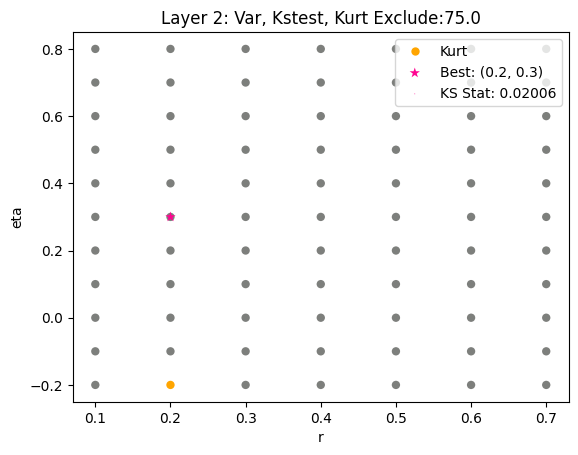

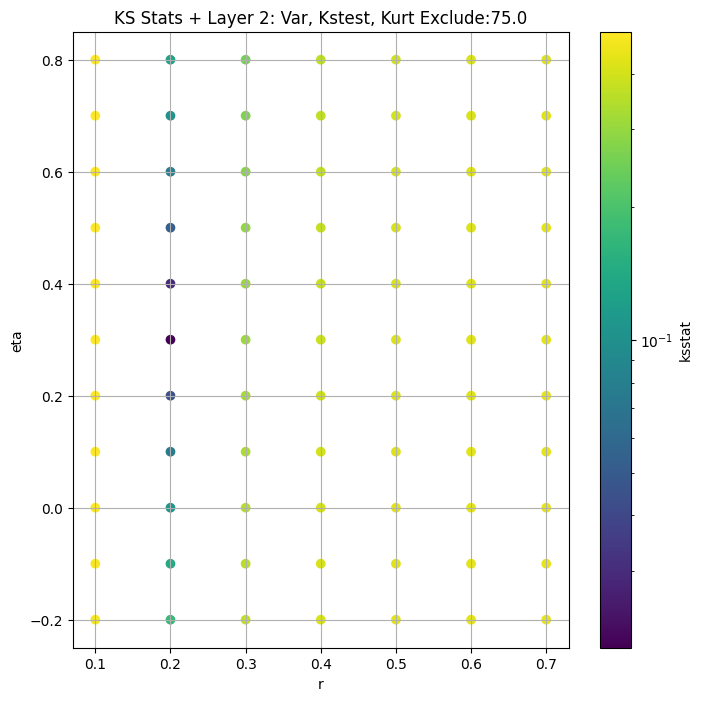

####
Layer  3


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 0 0.22193840047044966 1374.6909


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 25 0.22193840047044966 1278.1302


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 50 0.22193840047044966 1226.0255


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 75 0.22193840047044966 1183.445


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 100 0.22193840047044966 1147.0099


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 150 0.22193840047044966 1085.346


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 200 0.22193840047044966 1034.4391


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 250 0.22193840047044966 990.44073


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 300 0.22193840047044966 951.2793


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 350 0.22193840047044966 915.66925


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
3 500 0.22193840047044966 825.5042
Number of samples: 54416, Without approximation : 54416


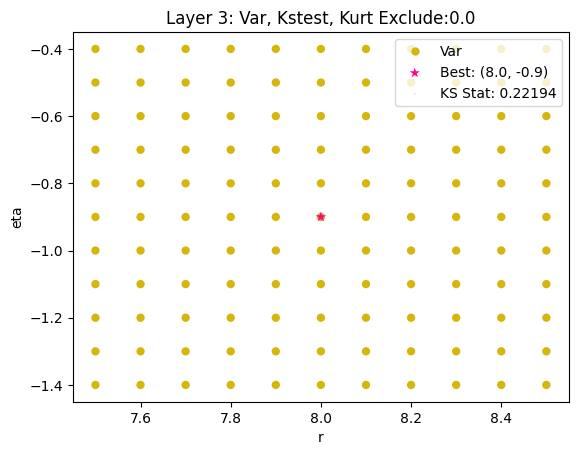

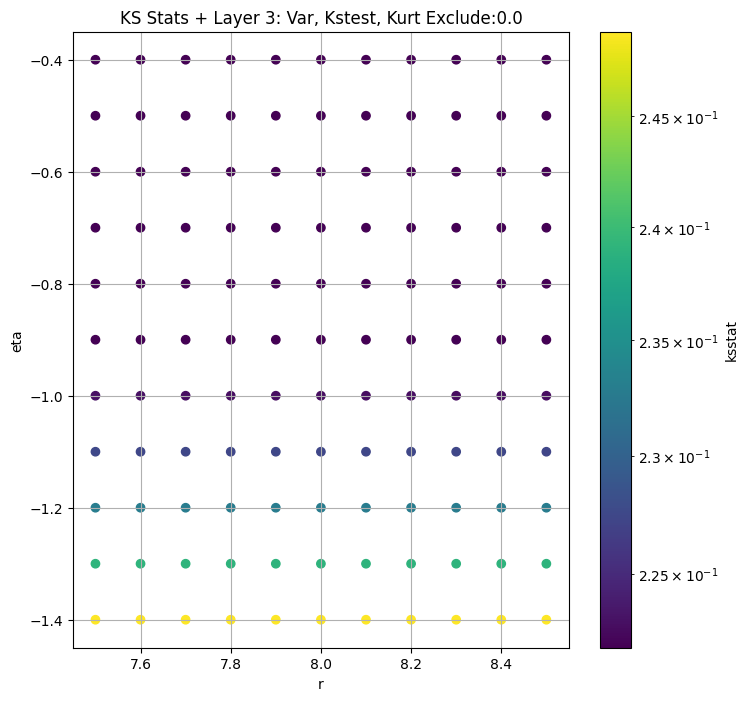

####
Layer  4


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 0 0.13309999999999989 583.37256


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 25 0.13309999999999989 560.8852


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 50 0.13309999999999989 546.8008


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 75 0.13309999999999989 535.0201


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 100 0.13309999999999989 524.7462


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 150 0.13309999999999989 507.1427


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 200 0.13309999999999989 492.0652


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 250 0.13309999999999989 478.4601


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 300 0.13309999999999994 466.21542


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 350 0.13309999999999994 455.06018


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
4 500 0.13309999999999994 426.1922
Number of samples: 100000, Without approximation : 166649


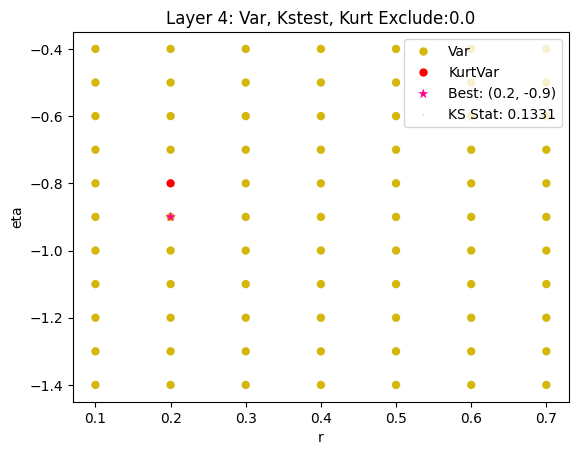

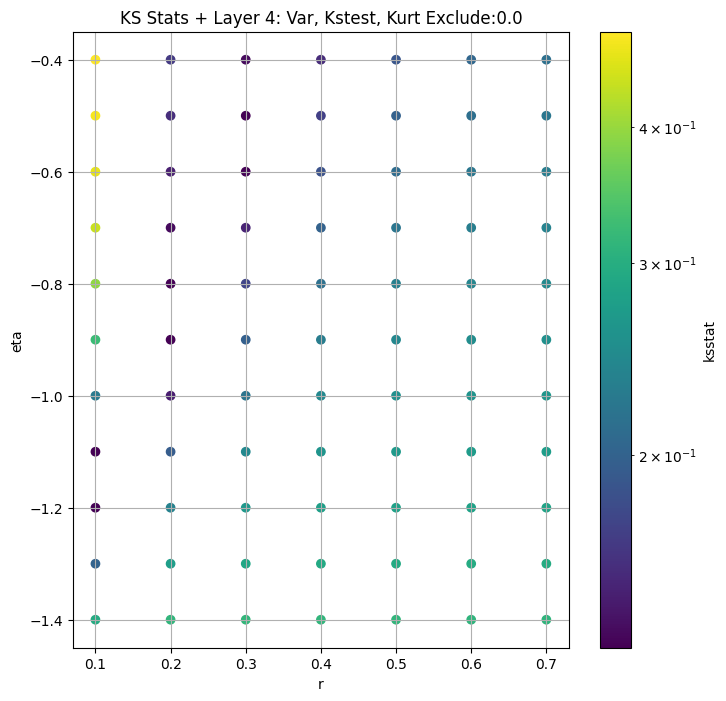

####
Layer  5


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 0 0.0744399999999999 161.01833


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 25 0.0744399999999999 155.0556


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 50 0.0744399999999999 151.30048


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 75 0.0744399999999999 148.22098


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 100 0.07472348395171624 145.51276


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 150 0.07756697106657295 140.78491


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 200 0.07986762751040424 136.70392


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 250 0.07981798230881637 133.09662


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 300 0.07906741477373691 129.8349


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 350 0.07841076817951825 126.84428


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
5 500 0.07679821865036113 119.04038
Number of samples: 100000, Without approximation : 574769


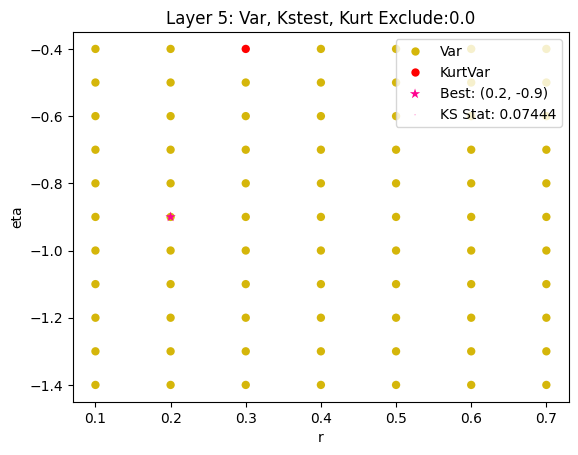

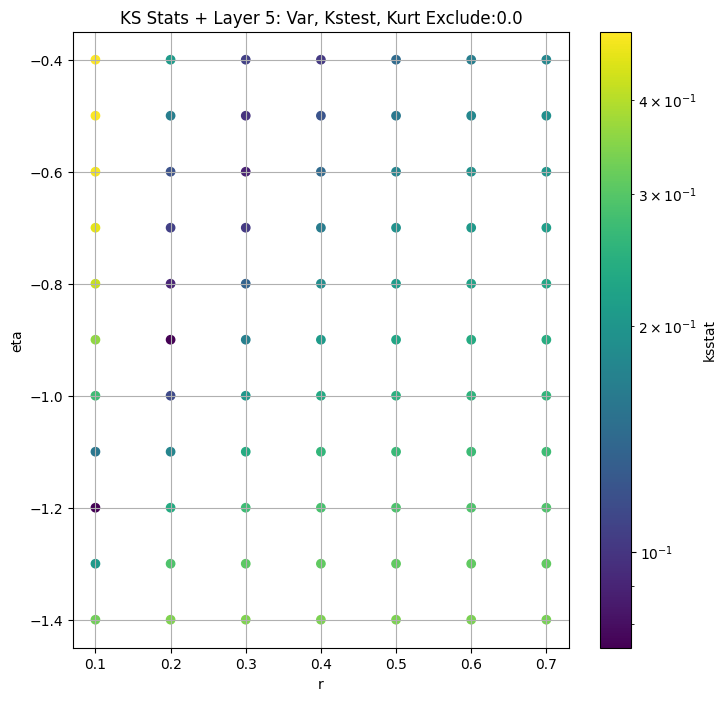

####
Layer  6


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 0 0.03872150947367159 39.27398


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 25 0.028746959051501264 37.616745


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 50 0.02471149761056627 36.65096


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 75 0.02205327389195412 35.869663


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 100 0.020121701139947063 35.195274


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 150 0.021941941626062222 34.042007


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 200 0.026159128687746058 33.055397


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 250 0.02967726915999891 32.186615


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 300 0.03273643999509823 31.403154


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 350 0.035504267970147496 30.68318


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
6 500 0.03859642257824503 28.810389
Number of samples: 100000, Without approximation : 2125625


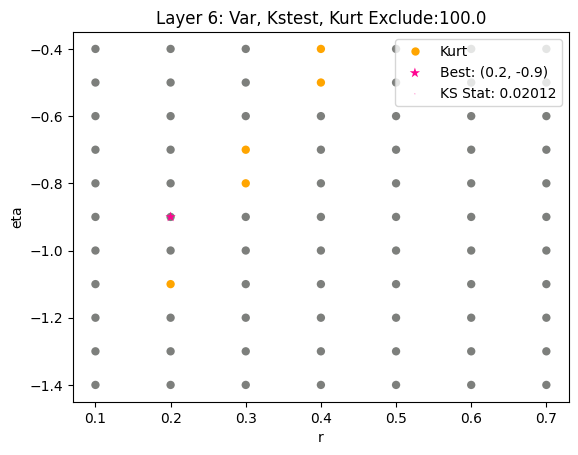

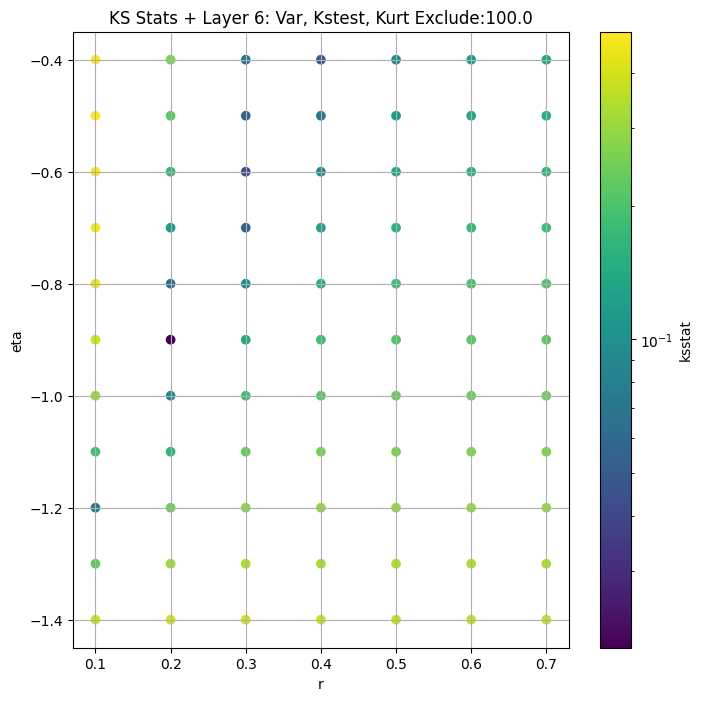

####
Layer  7


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 0 0.012599823747268313 9.062507


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 25 0.025261964838241002 8.5205345


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 50 0.020299117689233093 8.236115


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 75 0.016867589009037676 8.009802


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 100 0.014248326937940592 7.817287


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 150 0.01679331272076323 7.4932685


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 200 0.022071129864548955 7.2227697


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 250 0.026511700816442163 6.987834


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 300 0.03031531587173275 6.7791324


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 350 0.03311369947921529 6.5902896


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
7 500 0.02798758939636648 6.1099358
Number of samples: 100000, Without approximation : 8502500


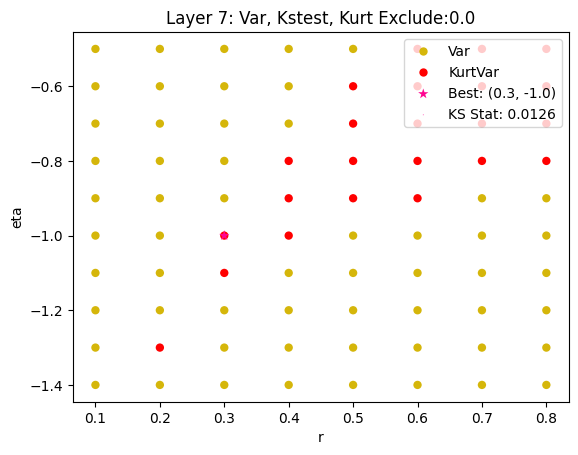

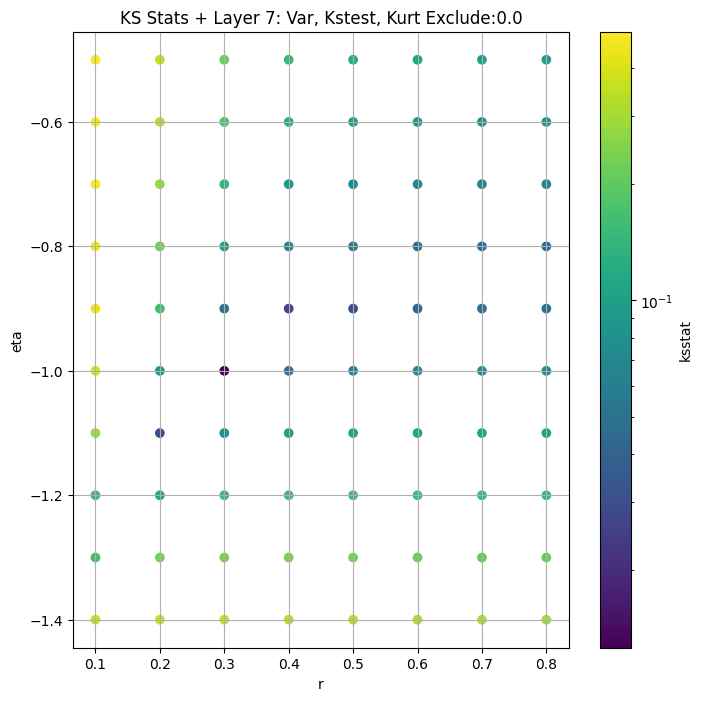

####
Layer  8


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 0 0.03339846394039153 1.9678569


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 25 0.018499101674939233 1.7766958


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 50 0.014836960672163224 1.6990172


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 75 0.013506607410400884 1.6401916


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 100 0.016935418096337695 1.5915914


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 150 0.019161549984431647 1.5123781


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 200 0.02238723598014636 1.4481018


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 250 0.023497543478980587 1.3934587


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 300 0.018924030050043394 1.3456827


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 350 0.01513238523015853 1.3031082


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
8 500 0.010791555181889567 1.1970007
Number of samples: 100000, Without approximation : 34010000


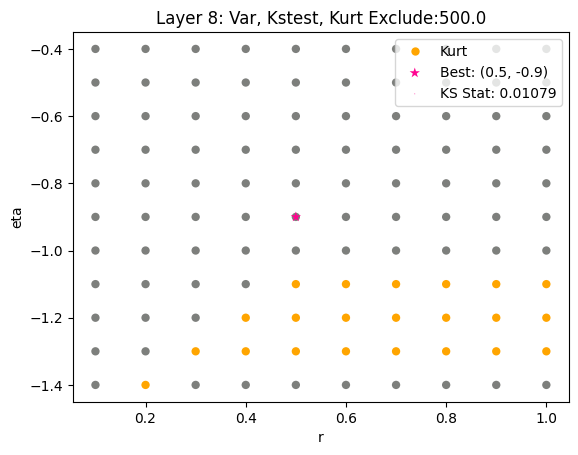

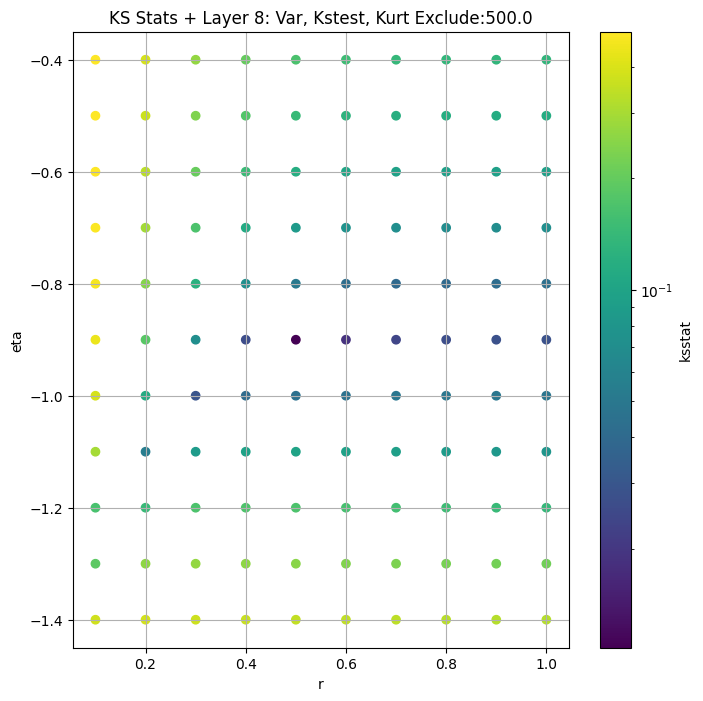

####
Layer  9


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 0 0.08094047782629066 0.34983853


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 25 0.04590375686021697 0.30113453


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 50 0.040452543977368416 0.28890225


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 75 0.0362794869408426 0.27990645


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 100 0.03347847313488461 0.27255934


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 150 0.03187165031571437 0.260689


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 200 0.031140715860557 0.25111032


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 250 0.030651464761938696 0.24296957


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 300 0.030207755420103843 0.23584281


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 350 0.029493735417270517 0.22947566


  0%|          | 0/12720 [00:00<?, ?it/s]

Finding Minimum after computing 12720 CDFs
9 500 0.02527973258591021 0.21352725
Number of samples: 100000, Without approximation : 136040000


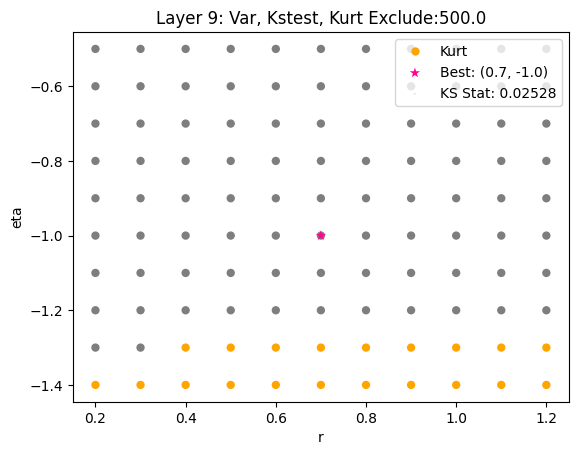

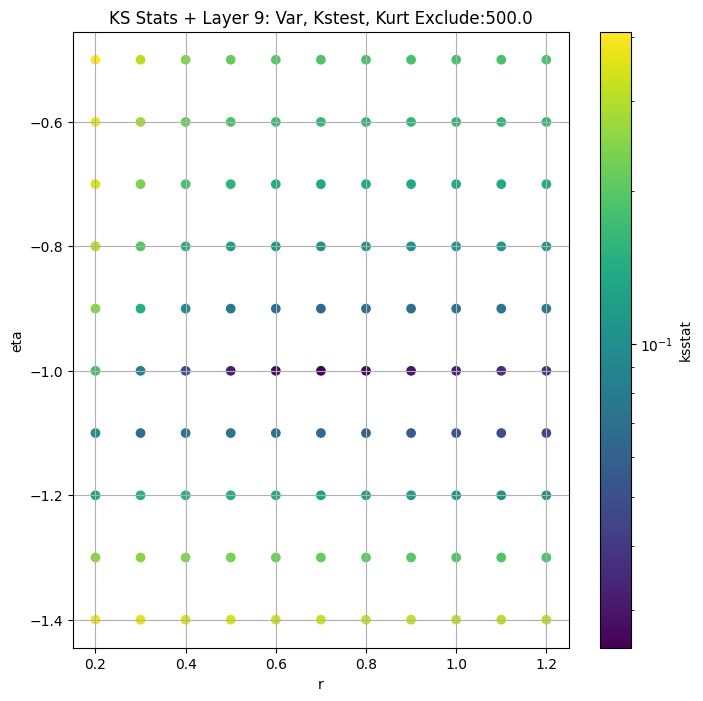

obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9382.064453  8727.582031  10077.744141    5.738890    3.878658   
3      1374.690918  1242.118530   1524.680054   14.064596    9.466524   
4       583.372559   530.836365    640.124695   11.037436    8.035024   
5       161.018326   147.046570    175.983200   10.230708    7.579123   
6        39.273979    35.769203     43.227554   11.540079    7.643221   
7         9.062507     8.068499     10.313087   20.645525   11.093557   
8         1.967857     1.680876      2.520643   60.267502   15.181164   
9         0.349839     0.287847      0.558240  220.299255   12.184872   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.221848          13604             0.020056        0.2          0.3   
3       23.382521          54416             0.221938        8.0         -0.9   
4       17.098072         166649             0.133100        0.2         -0.9   
5       14.656498         574769             0.074440        0.2         -0.9   
6       22.754463        2125625             0.020122        0.2         -0.9   
7       57.528484        8502500             0.012600        0.3         -1.0   
8      273.336731       34010000             0.010792        0.5         -0.9   
9      840.170227      136040000             0.025280        0.7         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.090683                    75.0         7381.472168   
3           6.956222                     0.0         1374.690918   
4           0.100210                     0.0          583.372559   
5           0.092886                     0.0          161.018326   
6           0.056194                   100.0           35.195274   
7           0.472045                     0.0            9.062507   
8           0.462484                   500.0            1.197001   
9           0.446682                   500.0            0.213527   

       kstest_stat_cutoff_0.05  
layer                           
2                     0.011632  
3                     0.005819  
4                     0.003326  
5                     0.001791  
6                     0.000931  
7                     0.000466  
8                     0.000233  
9                     0.000116

In [12]:
master_df_combo_path = Path(os.path.join(CWD, "CSVs", "master_df_combo.csv"))
rEtaKsstats_dict_path = Path(os.path.join(CWD, "cache", "rEtaKsstats_dict.pickle"))

rEtaKsstats_dict = dict()

if RERUN or not master_df_combo_path.exists():
    sorted_params = sorted(all_cdfs)
    ksstats_dict = dict()

    for i, group in enumerate(GROUPS): # TODO For quick testing purposes
        print(f"####\n{GROUP.capitalize()} ", group)
        sample = group_data_map[group]
        if len(sample) == 0:
            continue
        group_cdfs_df = all_cdfs_df.copy()
        master_df.loc[group, 'kstest_stat_initial'] = 1

        for j in range(len(EXCLUDE_CUTOFFS)):

            exclude_cutoff = EXCLUDE_CUTOFFS[j]
            exclude_cutoff = int(exclude_cutoff)

            if exclude_cutoff == 0:
                augmented_var = np.var(group_data_map[group]) 
            else:
                augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_var == np.var(group_data_map[group]):
                    continue 
            
            if exclude_cutoff == 0:
                augmented_kurt = stats.kurtosis(group_data_map[group]) 
            else:
                augmented_kurt = stats.kurtosis(group_data_map[group][exclude_cutoff:-exclude_cutoff])
                if augmented_kurt == stats.kurtosis(group_data_map[group]):
                    continue 

        
            group_cdfs_df['scale'] = np.clip((augmented_kurt / group_cdfs_df['kurtosis']), 0,  SCALE_CAP)
            #group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
            ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs, debug=True, scales=group_cdfs_df['scale'])
            augmented_var_df.loc[group, f"kstest_stat_{exclude_cutoff}"] = min_stat
            group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] = ksstats
            
            print(group, exclude_cutoff, min_stat, augmented_var)
            
            if (min_stat < master_df.loc[group, 'kstest_stat_initial']) and not np.isclose(min_stat, master_df.loc[group, 'kstest_stat_initial'], 1e-6):
                inital_min_stat = min_stat
                inital_best_param = initial_param
                master_df.loc[group, 'kstest_stat_initial'] = min_stat
                initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                master_df.loc[group, 'initial_r'], master_df.loc[group, 'initial_eta'] = initial_param
                master_df.loc[group, 'initial_scale'] = initial_scale
                master_df.loc[group, 'initial_exclude_cutoff'] = exclude_cutoff
                master_df.loc[group, 'best_augmented_var'] = augmented_var
        
        ksstats = group_cdfs_df[f"ksstat_exclude_{int(master_df.loc[group, 'initial_exclude_cutoff'])}"]
            
        print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
        
        cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
        master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

        best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

        group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
        group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

        group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

        group_dict = {'r' : group_cdfs_df['r'], 'eta' : group_cdfs_df['eta']}
        group_dict.update({f'ksstat_exclude_{exclude_cutoff}' : group_cdfs_df[f'ksstat_exclude_{exclude_cutoff}'] for exclude_cutoff in EXCLUDE_CUTOFFS[:j+1]})
        rEtaKsstats_dict[group] = group_dict

        cols = ['pass_var', 'pass_kstest', 'pass_kurt']

        fig = combo_test_plot(group_cdfs_df, cols, 
                            plot_name=f"{GROUP.capitalize()} {group}: {', '.join([col[5:].capitalize() for col in cols])} Exclude:{master_df.loc[group, 'initial_exclude_cutoff']}", 
                            target_var = None,
                            best_param = inital_best_param,
                            best_ksstat=inital_min_stat
                            )
        
        #fig.figure.savefig(os.path.join(CWD, "plots", f"full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)

        # Optional: 
        # Create plots of bootstrapped variance and kurtosis for varying confidence intervals
        # fig_var = create_ci_scatter_plot(group_cdfs_df, var_values_dict, metric='variance', group=group)
        # fig_kurt = create_ci_scatter_plot(group_cdfs_df, kurt_values_dict, metric='kurtosis', group=group)

        # fig_var.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_var)
        # fig_kurt.savefig(os.path.join(CWD, "plots", f"ci_scatter_variance_{GROUP}_{group}_bootstrap{n_bootstrap}.jpg"), bbox_inches='tight')
        # plt.close(fig_kurt)

    #master_df.to_csv(master_df_combo_path)
    #pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)
    #augmented_var_df.to_csv(augmented_var_df_path)

#augmented_var_df = pd.read_csv(augmented_var_df_path, index_col=GROUP)
#master_df = pd.read_csv(master_df_combo_path, index_col=GROUP)
#rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
master_df

## Optimization

In [13]:
master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
master_df[f'best_r'] = master_df['initial_r']
master_df[f'best_eta'] = master_df['initial_eta']
master_df[f'best_scale'] = master_df['initial_scale']
master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

Layer 2


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + 100 = 175, ksstat: nan, var: 6275.154296875


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + 75 = 150, ksstat: nan, var: 6502.66259765625


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + 50 = 125, ksstat: nan, var: 6756.12060546875


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + 25 = 100, ksstat: nan, var: 7042.62646484375


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + 0 = 75, ksstat: nan, var: 7381.47216796875


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + -25 = 50, ksstat: nan, var: 7798.54248046875


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + -50 = 25, ksstat: nan, var: 8342.8271484375


  0%|          | 0/747 [00:00<?, ?it/s]

Finding Minimum after computing 747 CDFs
layer 2, 75.0 + -75 = 0, ksstat: nan, var: 9382.064453125
Number of samples: 13604, Without approximation : 13604


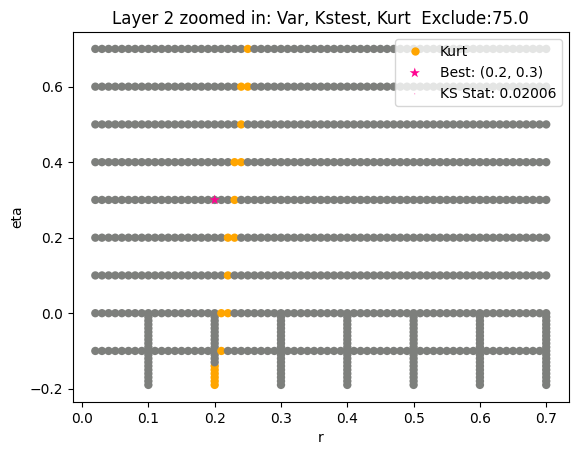

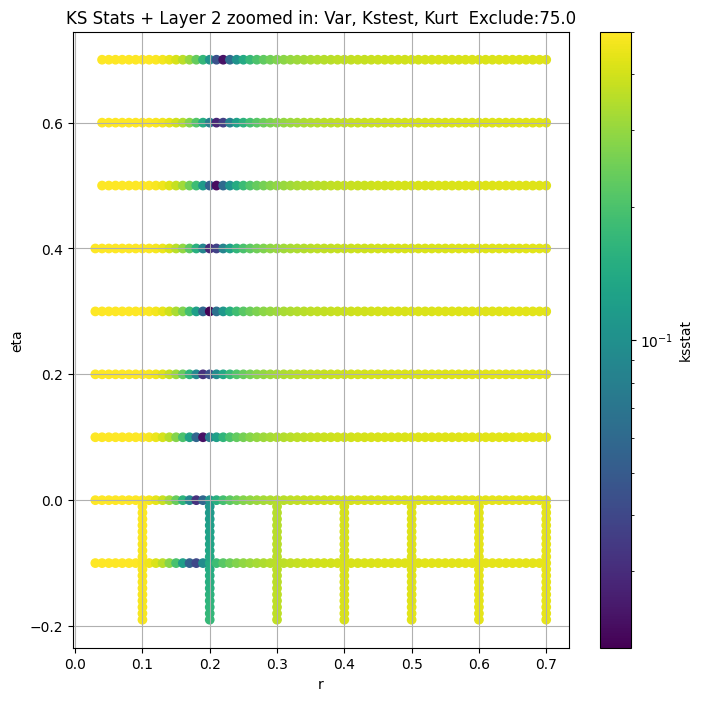

Layer 3


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 3, 0.0 + 100 = 100, ksstat: 0.22193840047044971, var: 1147.0098876953125


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 3, 0.0 + 75 = 75, ksstat: 0.22193840047044971, var: 1183.4449462890625


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 3, 0.0 + 50 = 50, ksstat: 0.22193840047044971, var: 1226.0255126953125


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 3, 0.0 + 25 = 25, ksstat: 0.22193840047044971, var: 1278.1302490234375


  0%|          | 0/180 [00:00<?, ?it/s]

Finding Minimum after computing 180 CDFs
layer 3, 0.0 + 0 = 0, ksstat: 0.22193840047044966, var: 1374.69091796875
Number of samples: 54416, Without approximation : 54416


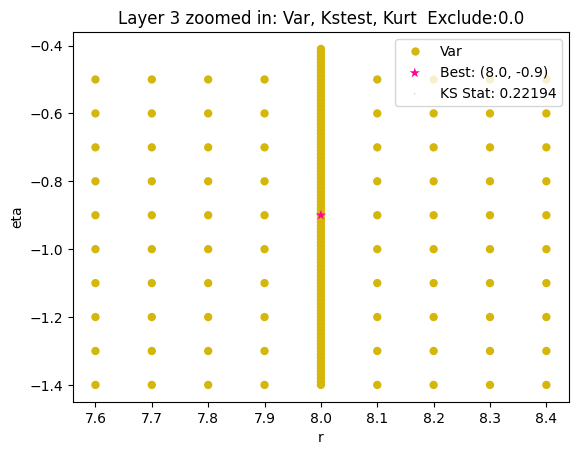

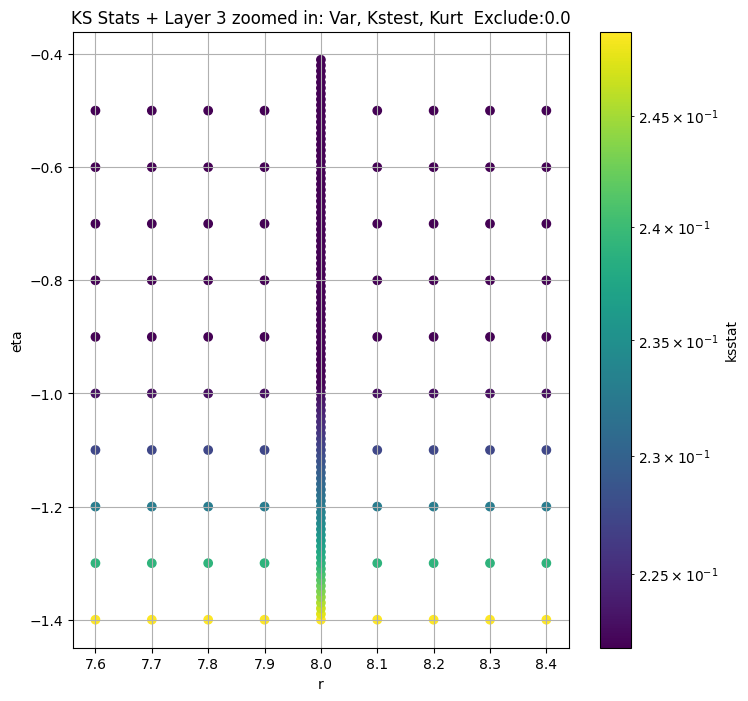

Layer 4


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 4, 0.0 + 100 = 100, ksstat: nan, var: 524.7462158203125


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 4, 0.0 + 75 = 75, ksstat: nan, var: 535.0200805664062


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 4, 0.0 + 50 = 50, ksstat: nan, var: 546.80078125


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 4, 0.0 + 25 = 25, ksstat: nan, var: 560.8851928710938


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 4, 0.0 + 0 = 0, ksstat: nan, var: 583.37255859375
Number of samples: 100000, Without approximation : 166649


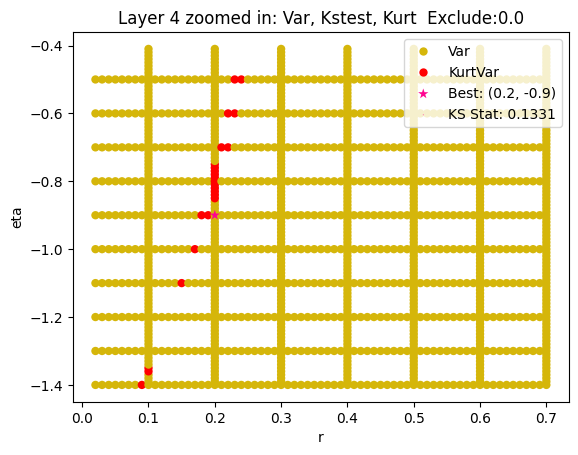

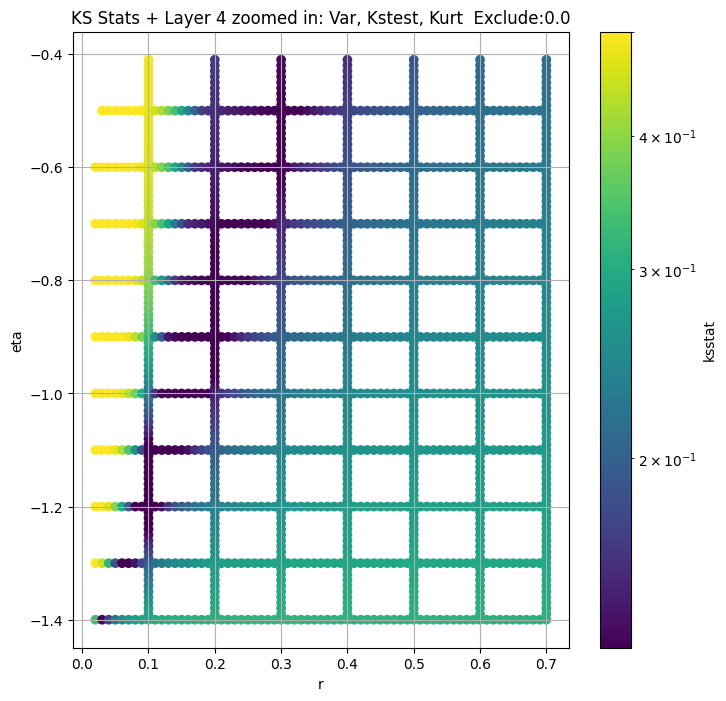

Layer 5


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 5, 0.0 + 100 = 100, ksstat: nan, var: 145.51275634765625


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 5, 0.0 + 75 = 75, ksstat: nan, var: 148.22097778320312


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 5, 0.0 + 50 = 50, ksstat: nan, var: 151.30047607421875


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 5, 0.0 + 25 = 25, ksstat: nan, var: 155.05560302734375


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 5, 0.0 + 0 = 0, ksstat: nan, var: 161.01832580566406
Number of samples: 100000, Without approximation : 574769


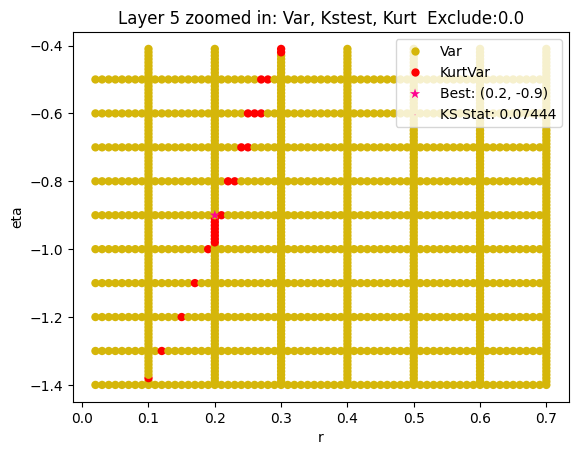

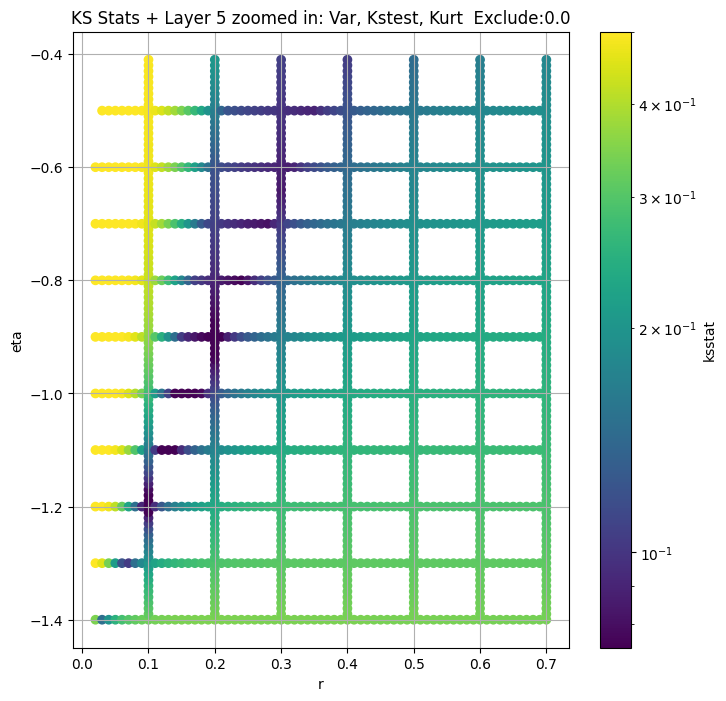

Layer 6


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + 100 = 200, ksstat: nan, var: 33.055397033691406


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + 75 = 175, ksstat: nan, var: 33.5313835144043


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + 50 = 150, ksstat: nan, var: 34.04200744628906


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + 25 = 125, ksstat: nan, var: 34.59275817871094


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + 0 = 100, ksstat: nan, var: 35.195274353027344


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + -25 = 75, ksstat: nan, var: 35.86966323852539


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + -50 = 50, ksstat: nan, var: 36.65095901489258


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + -75 = 25, ksstat: nan, var: 37.61674499511719


  0%|          | 0/1320 [00:00<?, ?it/s]

Finding Minimum after computing 1320 CDFs
layer 6, 100.0 + -100 = 0, ksstat: nan, var: 39.27397918701172
Number of samples: 100000, Without approximation : 2125625


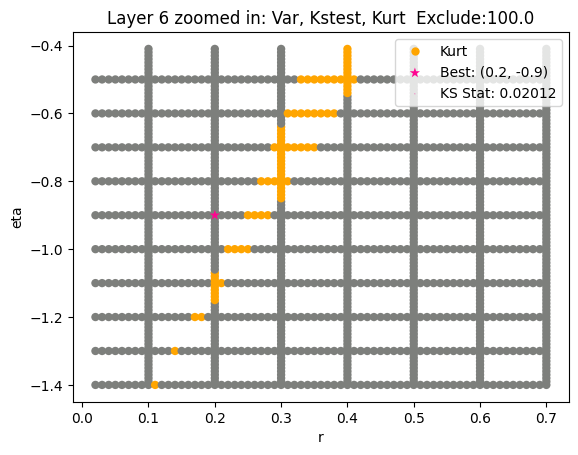

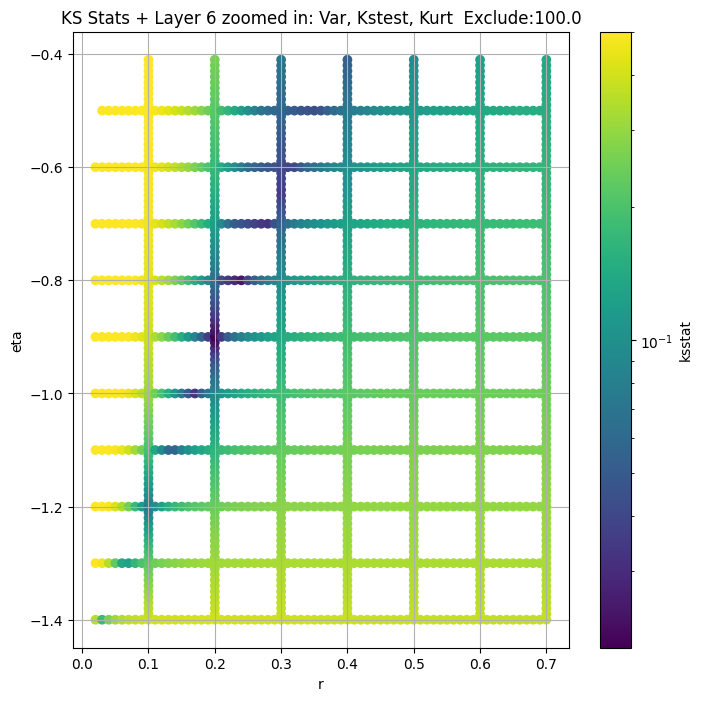

Layer 7


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 7, 0.0 + 100 = 100, ksstat: 0.014248326937940592, var: 7.817286968231201


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 7, 0.0 + 75 = 75, ksstat: 0.012863623846971317, var: 8.009801864624023


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 7, 0.0 + 50 = 50, ksstat: 0.012115304791518011, var: 8.236115455627441


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 7, 0.0 + 25 = 25, ksstat: 0.011701348236143772, var: 8.52053451538086


  0%|          | 0/1304 [00:00<?, ?it/s]

Finding Minimum after computing 1304 CDFs
layer 7, 0.0 + 0 = 0, ksstat: 0.006567622963005726, var: 9.062506675720215
Number of samples: 100000, Without approximation : 8502500


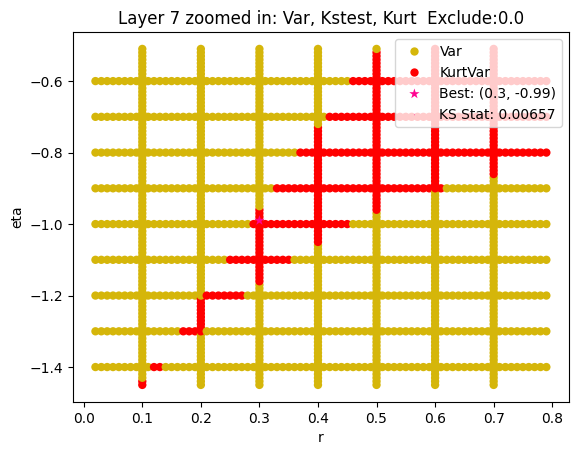

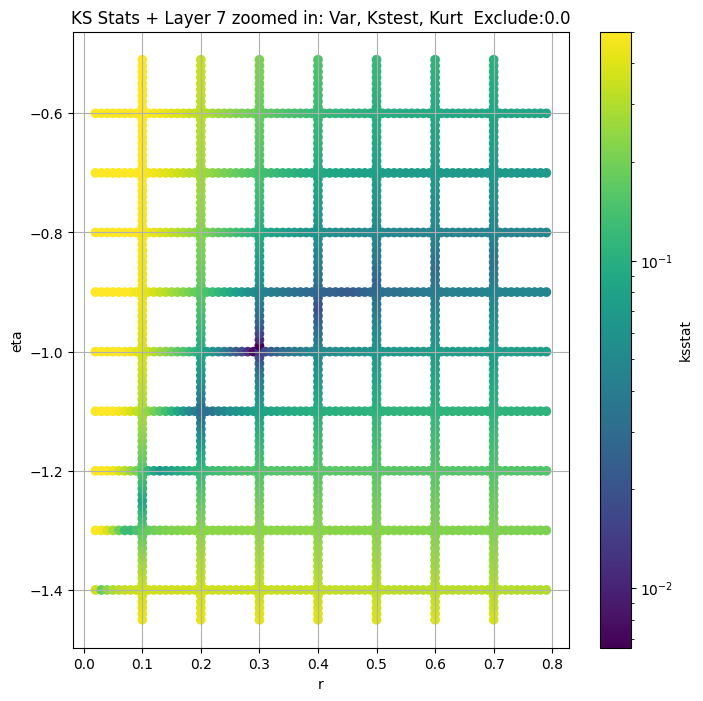

Layer 8


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + 100 = 600, ksstat: nan, var: 1.1388094425201416


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + 75 = 575, ksstat: nan, var: 1.1526199579238892


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + 50 = 550, ksstat: nan, var: 1.166900634765625


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + 25 = 525, ksstat: nan, var: 1.1816829442977905


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + 0 = 500, ksstat: nan, var: 1.1970007419586182


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + -25 = 475, ksstat: nan, var: 1.2128956317901611


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + -50 = 450, ksstat: nan, var: 1.2294206619262695


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + -75 = 425, ksstat: nan, var: 1.246639609336853


  0%|          | 0/1790 [00:00<?, ?it/s]

Finding Minimum after computing 1790 CDFs
layer 8, 500.0 + -100 = 400, ksstat: nan, var: 1.2646071910858154
Number of samples: 100000, Without approximation : 34010000


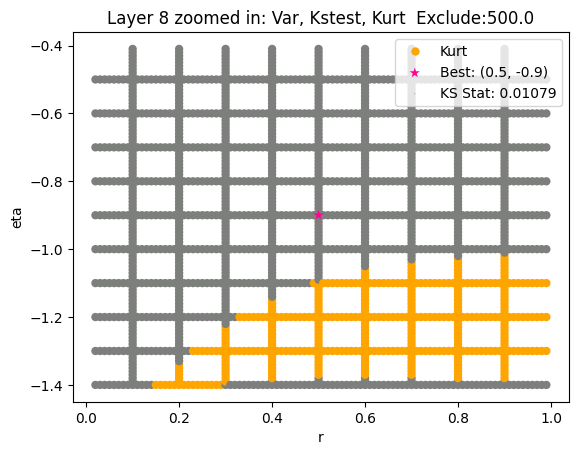

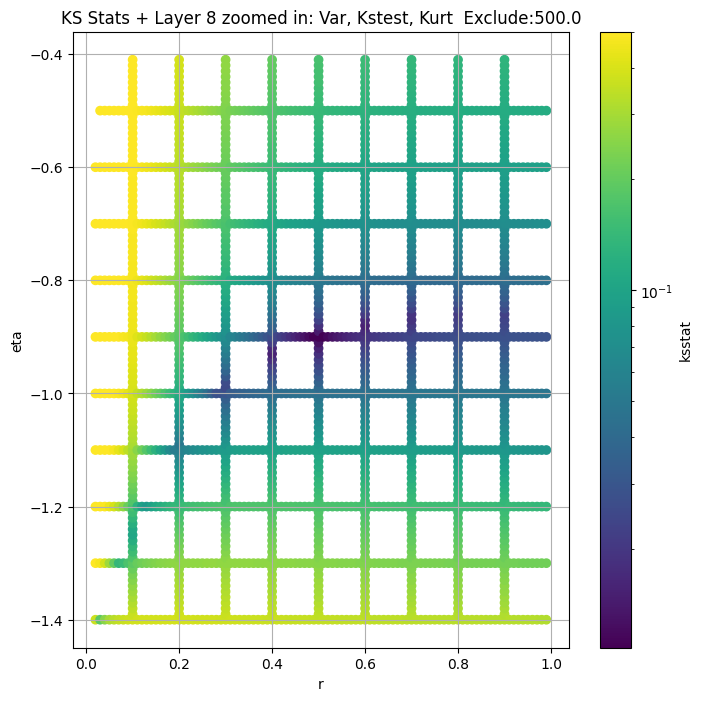

Layer 9


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + 100 = 600, ksstat: 0.022516433811120673, var: 0.20472121238708496


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + 75 = 575, ksstat: 0.022864501958037214, var: 0.20681554079055786


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + 50 = 550, ksstat: 0.02349448400724735, var: 0.20897799730300903


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + 25 = 525, ksstat: 0.023482251896521533, var: 0.2112135887145996


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + 0 = 500, ksstat: 0.024078769115132403, var: 0.21352724730968475


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + -25 = 475, ksstat: 0.024445591138336886, var: 0.21592535078525543


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + -50 = 450, ksstat: 0.024680807679236305, var: 0.21841512620449066


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + -75 = 425, ksstat: 0.02511880104385278, var: 0.22100482881069183


  0%|          | 0/1760 [00:00<?, ?it/s]

Finding Minimum after computing 1760 CDFs
layer 9, 500.0 + -100 = 400, ksstat: 0.025384124118479234, var: 0.2237037718296051
Number of samples: 100000, Without approximation : 136040000


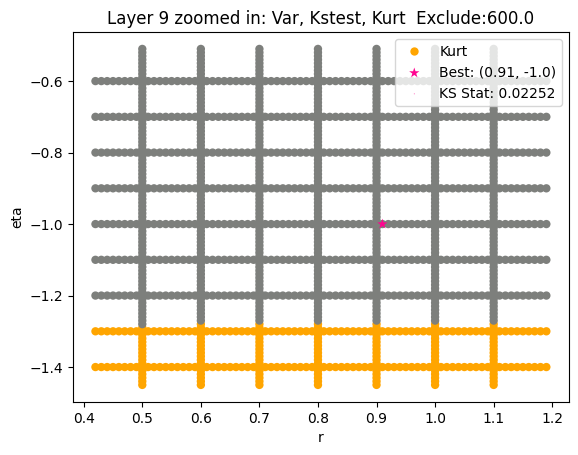

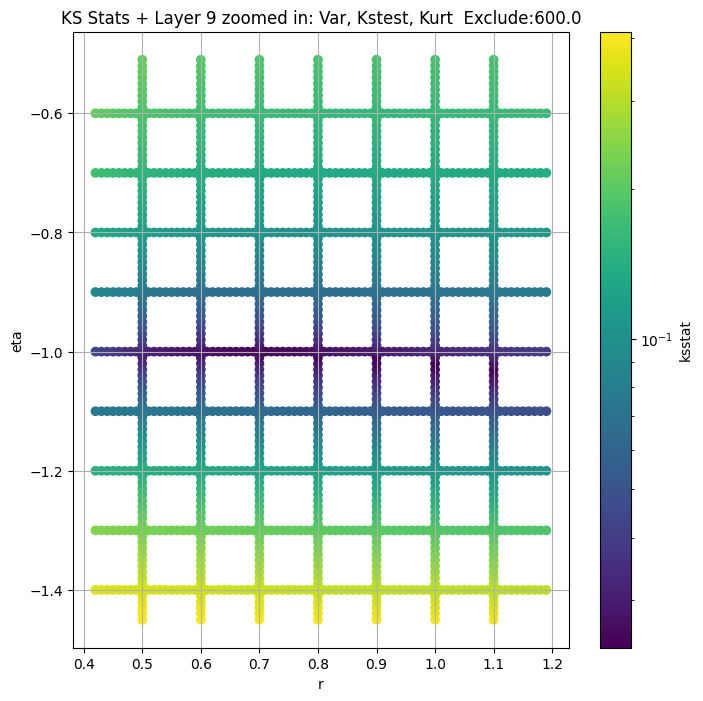

Not a fit


obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9382.064453  8727.582031  10077.744141    5.738890    3.878658   
3      1374.690918  1242.118530   1524.680054   14.064596    9.466524   
4       583.372559   530.836365    640.124695   11.037436    8.035024   
5       161.018326   147.046570    175.983200   10.230708    7.579123   
6        39.273979    35.769203     43.227554   11.540079    7.643221   
7         9.062507     8.068499     10.313087   20.645525   11.093557   
8         1.967857     1.680876      2.520643   60.267502   15.181164   
9         0.349839     0.287847      0.558240  220.299255   12.184872   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.221848          13604             0.020056        0.2          0.3   
3       23.382521          54416             0.221938        8.0         -0.9   
4       17.098072         166649             0.133100        0.2         -0.9   
5       14.656498         574769             0.074440        0.2         -0.9   
6       22.754463        2125625             0.020122        0.2         -0.9   
7       57.528484        8502500             0.012600        0.3         -1.0   
8      273.336731       34010000             0.010792        0.5         -0.9   
9      840.170227      136040000             0.025280        0.7         -1.0   

       initial_scale  initial_exclude_cutoff  best_augmented_var  \
layer                                                              
2           0.090683                    75.0         7381.472168   
3           6.956222                     0.0         1374.690918   
4           0.100210                     0.0          583.372559   
5           0.092886                     0.0          161.018326   
6           0.056194                   100.0           35.195274   
7           0.472045                     0.0            9.062507   
8           0.462484                   500.0            1.197001   
9           0.446682                   500.0            0.204721   

       kstest_stat_cutoff_0.05  kstest_stat_best  best_r  best_eta  \
layer                                                                
2                     0.011632          0.020056    0.20      0.30   
3                     0.005819          0.221938    8.00     -0.90   
4                     0.003326          0.133100    0.20     -0.90   
5                     0.001791          0.074440    0.20     -0.90   
6                     0.000931          0.020122    0.20     -0.90   
7                     0.000466          0.006568    0.30     -0.99   
8                     0.000233          0.010792    0.50     -0.90   
9                     0.000116          0.022516    0.91     -1.00   

       best_scale  best_exclude_cutoff  n_pval_0.05  
layer                                                
2        0.090683                 75.0         4839  
3        6.956222                  0.0           -1  
4        0.100210                  0.0          100  
5        0.092886                  0.0          315  
6        0.056194                100.0         4669  
7        0.485066                  0.0        42033  
8        0.462484                500.0        16606  
9        0.554640                600.0         3501

In [14]:
master_df_optimized_path = Path(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))

NUM_ITERS = dict(zip(GROUPS, [1]*len(GROUPS))) # By default, does one iteration per group
NUM_SAMPLES_OPTIMIZE = 2000
EXCLUDE_CUTOFFS_OPTIMIZE = np.arange(100, -101, -25)

if RERUN or not master_df_optimized_path.exists():

    if SKIP_OPTIMIZE_STEP:

        master_df['kstest_stat_best'] = master_df['kstest_stat_initial']
        master_df[f'best_r'] = master_df['initial_r']
        master_df[f'best_eta'] = master_df['initial_eta']
        master_df[f'best_scale'] = master_df['initial_scale']
        master_df[f'best_exclude_cutoff'] = master_df['initial_exclude_cutoff']

    else:
        for group in GROUPS: # TODO For quick testing purposes
            print(f"{GROUP.capitalize()} {group}")
            master_df.loc[group, 'kstest_stat_best'] = master_df.loc[group, 'kstest_stat_initial']
            master_df.loc[group, 'best_r'] = master_df.loc[group, 'initial_r']
            master_df.loc[group, 'best_eta'] = master_df.loc[group, 'initial_eta']
            master_df.loc[group, 'best_scale'] = master_df.loc[group, 'initial_scale']

            sample = group_data_map[group]
            if len(sample) == 0:
                continue
            initial_r, initial_eta = master_df.loc[group, 'initial_r'], master_df.loc[group, f'initial_eta']
            eps = 0.5
            group_cdfs_df = fine_cdfs_df[(np.abs(master_df.loc[group, 'initial_r'] - fine_cdfs_df['r']) < eps) & 
                                        (np.abs(master_df.loc[group, 'initial_eta'] - fine_cdfs_df['eta']) < eps)].reset_index(drop=True)
            group_cdfs = {x[0]:x[1] for x in group_cdfs_df['(r,eta),cdf']}

            for adjust_exclude_cutoff in EXCLUDE_CUTOFFS_OPTIMIZE: # -50, -25, 0, 25, 50
                
                exclude_cutoff = int(max(0, adjust_exclude_cutoff + master_df.loc[group, 'initial_exclude_cutoff']))
                
                if exclude_cutoff == 0:
                    augmented_var = np.var(group_data_map[group])
                else:
                    augmented_var = np.var(group_data_map[group][exclude_cutoff:-exclude_cutoff]) 
                                        
                if exclude_cutoff == 0:
                    augmented_kurt = stats.kurtosis(group_data_map[group])
                else:
                    augmented_kurt = stats.kurtosis(group_data_map[group][exclude_cutoff:-exclude_cutoff])

                group_cdfs_df['scale'] = np.clip((augmented_kurt / group_cdfs_df['kurtosis']), 0,  SCALE_CAP)
                #group_cdfs_df['scale'] = np.clip((augmented_var / group_cdfs_df['variance']), 0,  SCALE_CAP)
                ksstats, initial_param, min_stat = gridsearch(sample, group_cdfs, debug=True, scales=group_cdfs_df['scale'])
                
                cutoff_label = generate_cutoff_label(adjust_exclude_cutoff)

                augmented_var_df.loc[group, f"kstest_stat_{cutoff_label}"] = min_stat
                group_cdfs_df[f'ksstat_exclude_{cutoff_label}'] = ksstats
                
                print(f"{GROUP} {group}, {master_df.loc[group, 'initial_exclude_cutoff']} + {adjust_exclude_cutoff} = {exclude_cutoff}, ksstat: {min_stat}, var: {augmented_var}")
                best_adjust = 0

                if min_stat < master_df.loc[group, 'kstest_stat_best']:

                    inital_min_stat = min_stat
                    inital_best_param = initial_param
                    master_df.loc[group, 'kstest_stat_best'] = min_stat
                    initial_scale = group_cdfs_df.loc[(group_cdfs_df["r"] ==  initial_param[0]) & (group_cdfs_df["eta"] ==  initial_param[1])]["scale"].iloc[0]
                    master_df.loc[group, 'best_r'], master_df.loc[group, 'best_eta'] = initial_param
                    master_df.loc[group, 'best_scale'] = initial_scale
                    master_df.loc[group, 'best_exclude_cutoff'] = exclude_cutoff
                    master_df.loc[group, 'best_augmented_var'] = augmented_var
                    augmented_var_df.loc[group, 'best_augmented_var'] = augmented_var
                    best_adjust = adjust_exclude_cutoff

                if exclude_cutoff == 0:
                    break

            cutoff_label = generate_cutoff_label(best_adjust)
            ksstats = group_cdfs_df[f"ksstat_exclude_{cutoff_label}"]
            
            print(f"Number of samples: {sample.size}, Without approximation : {master_df.loc[group, 'total_samples']}")
            
            cutoff = stats.kstwo(n=master_df.loc[group, 'total_samples']).isf(0.05)
            master_df.loc[group, 'kstest_stat_cutoff_0.05'] = cutoff

            best_scales = np.clip((master_df.loc[group, 'best_augmented_var'] / group_cdfs_df['variance']), 0,  SCALE_CAP)

            group_cdfs_df['variance'] = group_cdfs_df['variance'] * best_scales
            group_cdfs_df['kurtosis'] = group_cdfs_df['kurtosis'] * best_scales

            group_cdfs_df = add_tests_to_df(cdfs_df = group_cdfs_df, group = group, var_kurt_df = master_df, ksstats = ksstats).sort_values(['r', 'eta'])

            group_dict = rEtaKsstats_dict[group]
            group_dict.update({'r_optimize' : group_cdfs_df['r'], 'eta_optimize' : group_cdfs_df['eta'], f'ksstat_exclude_{cutoff_label}' : ksstats})
            rEtaKsstats_dict[group] = group_dict

            cols = ['pass_var', 'pass_kstest', 'pass_kurt']
            fig = combo_test_plot(group_cdfs_df, cols, 
                                plot_name=f"{GROUP.capitalize()} {group} zoomed in: {', '.join([col[5:].capitalize() for col in cols])}  Exclude:{master_df.loc[group, 'best_exclude_cutoff']}",
                                best_param=(master_df.loc[group, 'best_r'], master_df.loc[group, f'best_eta']),
                                best_ksstat=master_df.loc[group, 'kstest_stat_best'])
            #fig.figure.savefig(os.path.join(CWD, "plots", f"optimized_full_grid_search_combo_plot_layer{group}.jpg"), bbox_inches = 'tight', dpi=100)
            
    master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_best'], row.loc['total_samples']), axis = 1)    
   #master_df[['total_samples', 'initial_r', 'initial_eta', 'kstest_stat_initial', 'initial_exclude_cutoff', 'best_r', 'best_eta', 'best_scale', 'kstest_stat_best', 'best_exclude_cutoff', 'n_pval_0.05']].to_csv(os.path.join(CWD, "CSVs", 'optimized_params.csv'))
    #master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df_optimized.csv'))
    #augmented_var_df.to_csv(augmented_var_df_path)
    #pd.to_pickle(rEtaKsstats_dict, rEtaKsstats_dict_path)

#rEtaKsstats_dict = pd.read_pickle(rEtaKsstats_dict_path)
#master_df = pd.read_csv(master_df_optimized_path, index_col = GROUP)
#augmented_var_df = pd.read_csv(augmented_var_df_path, index_col = GROUP)
master_df

## Comparing Empirical and Computed CDF/PDF

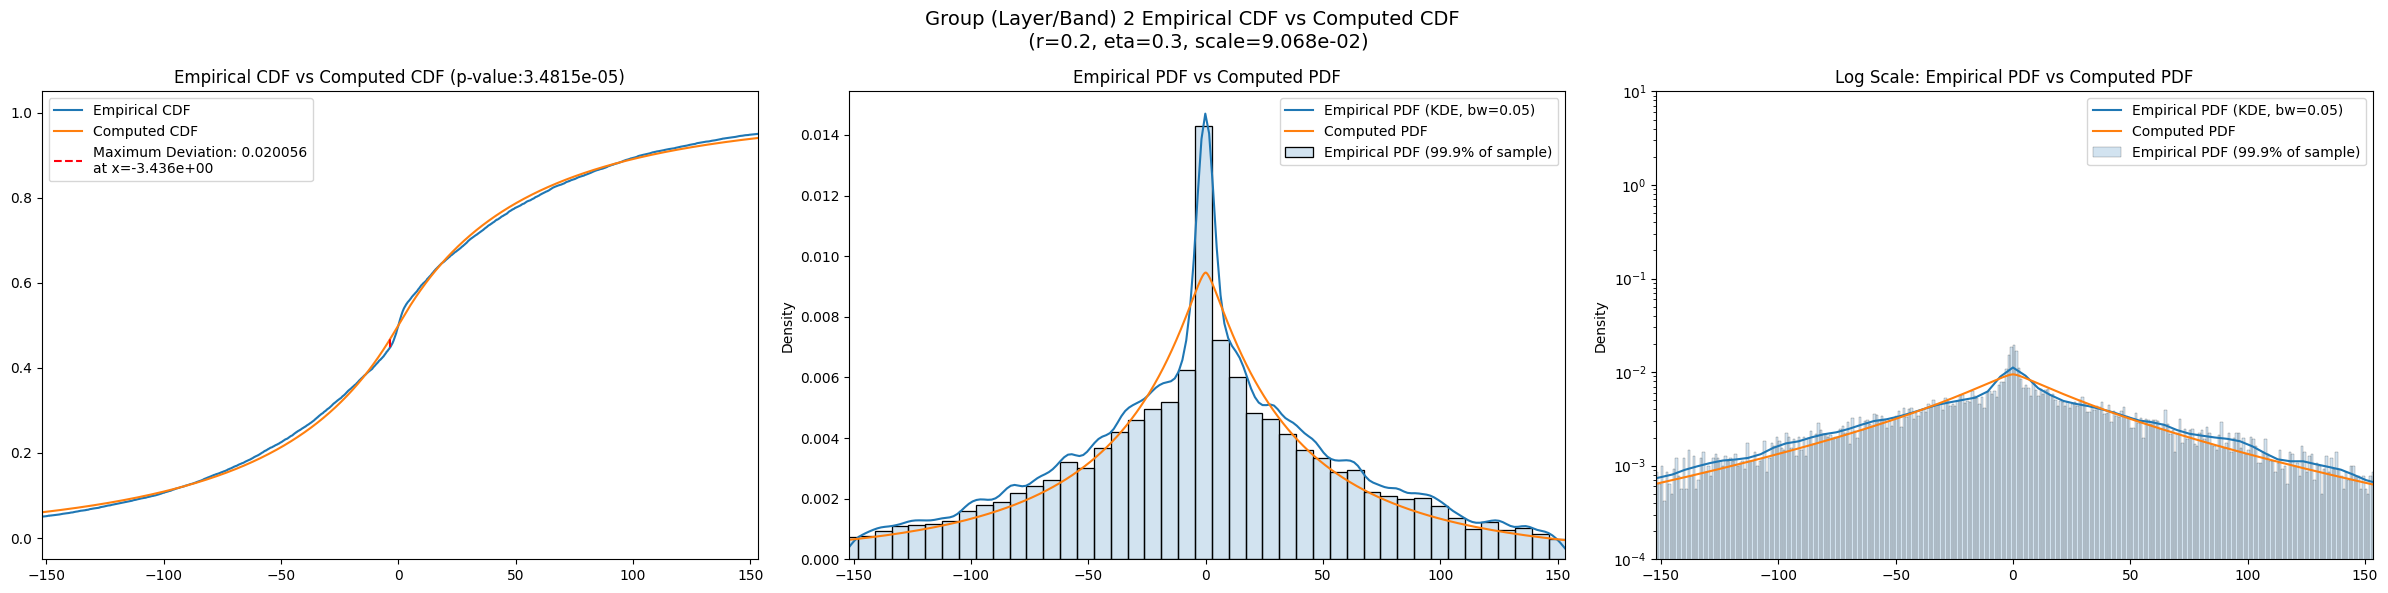

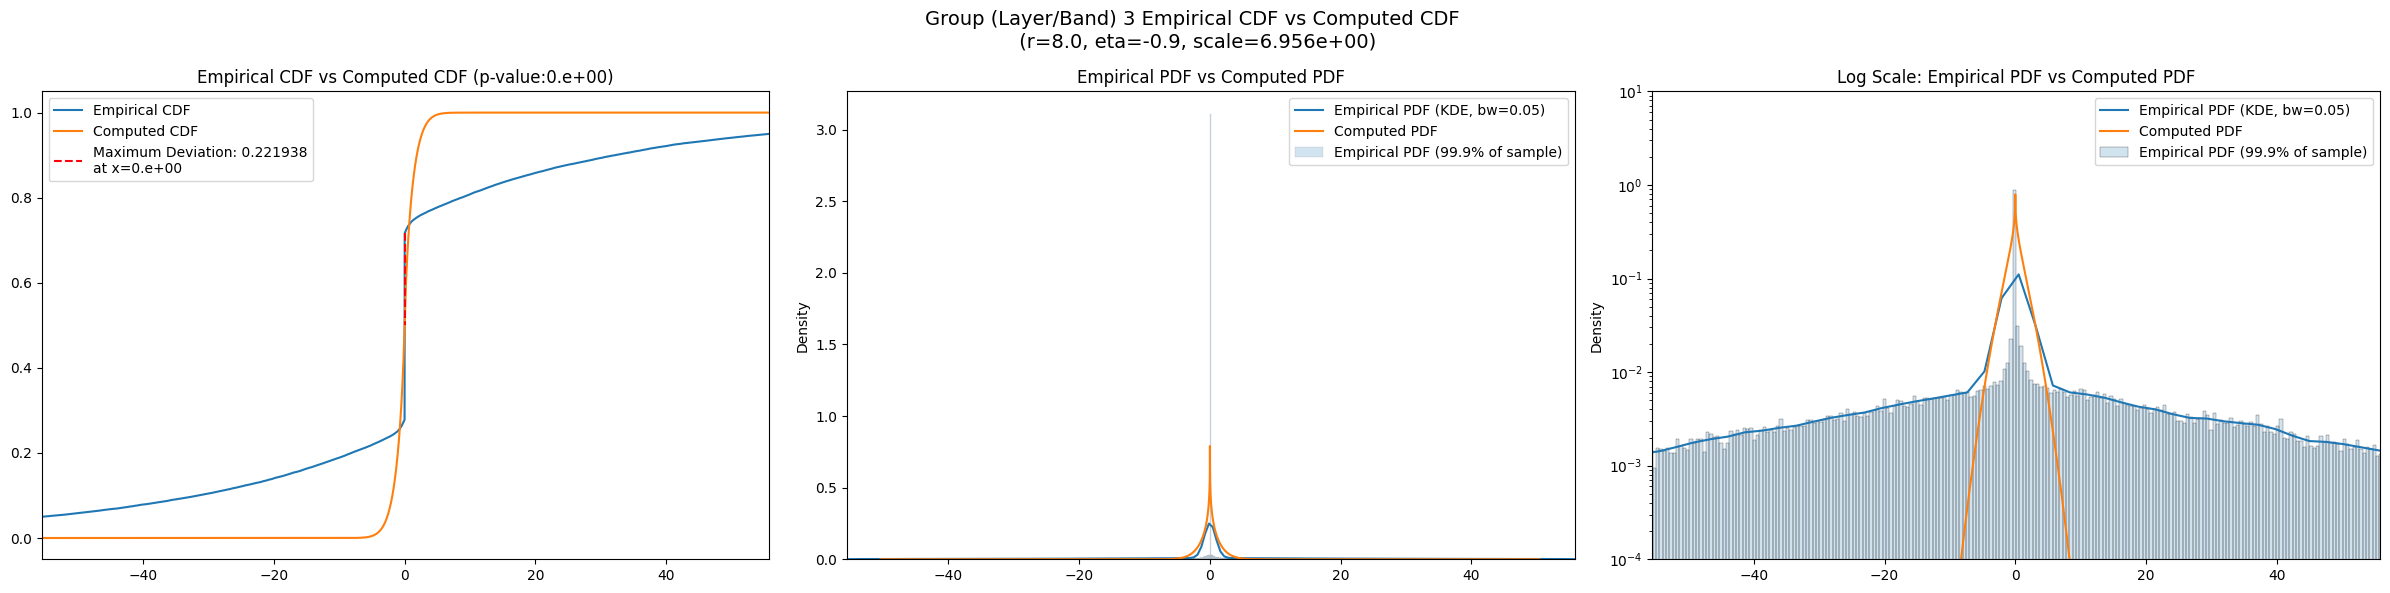

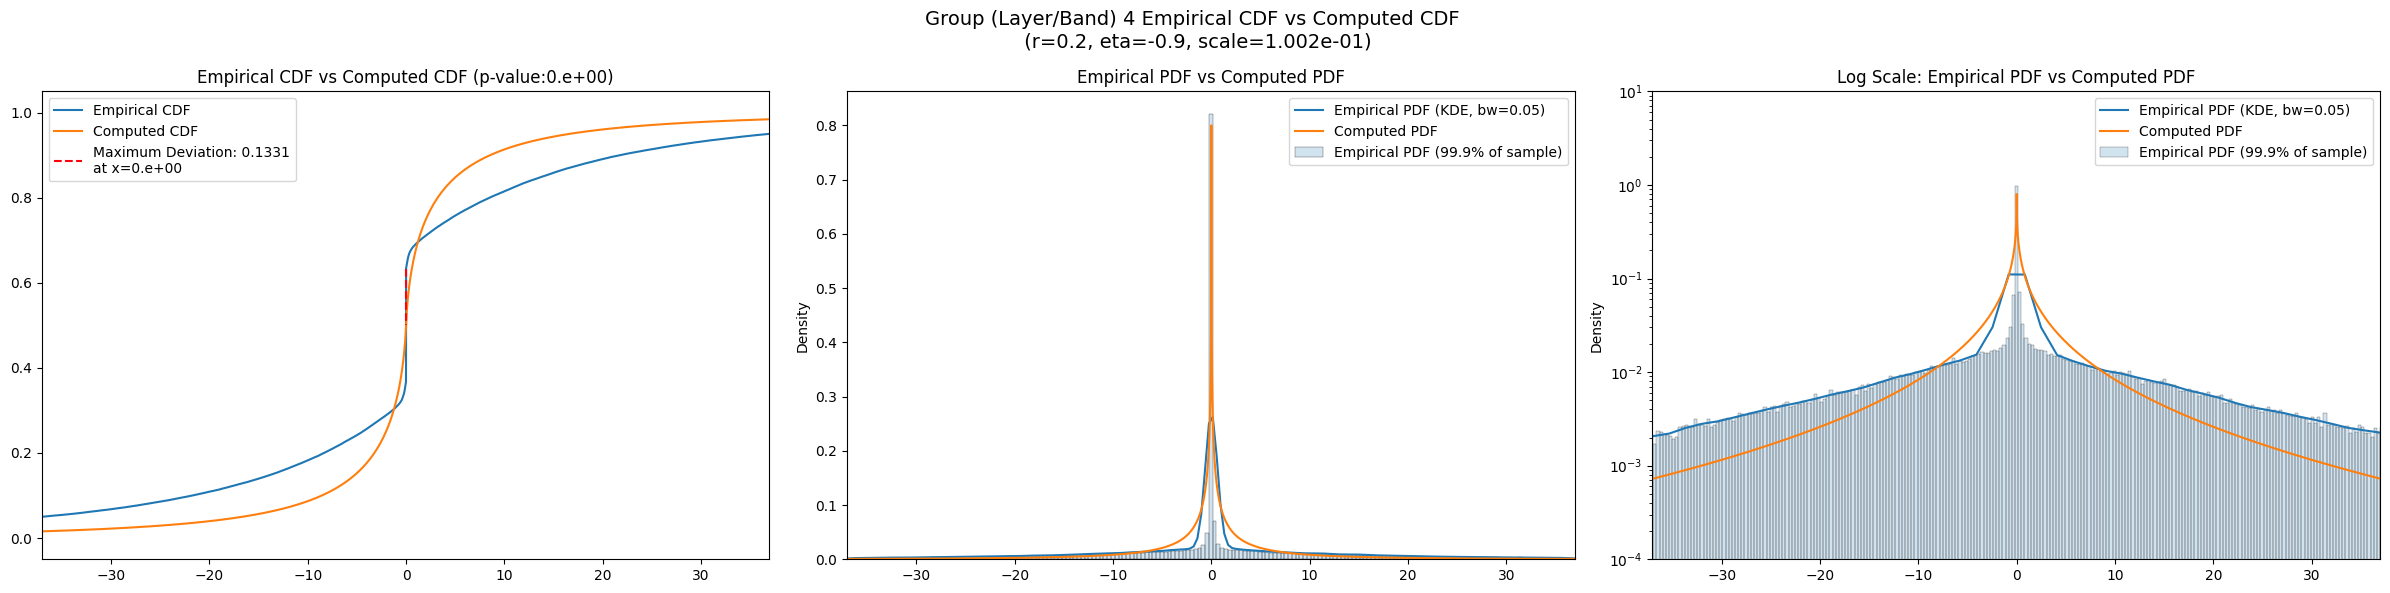

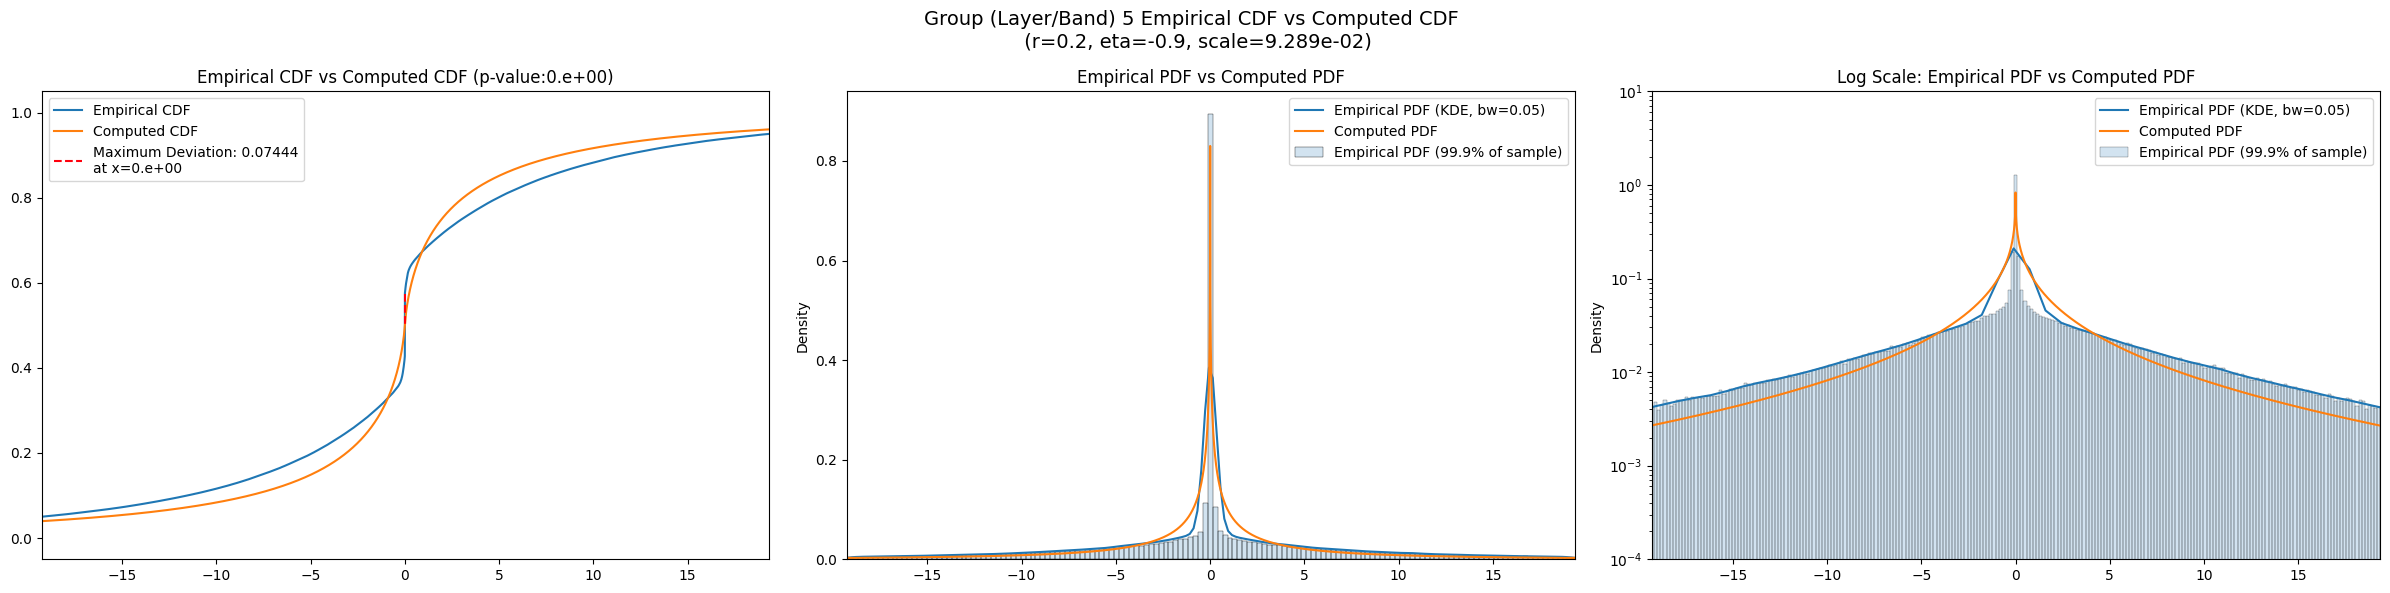

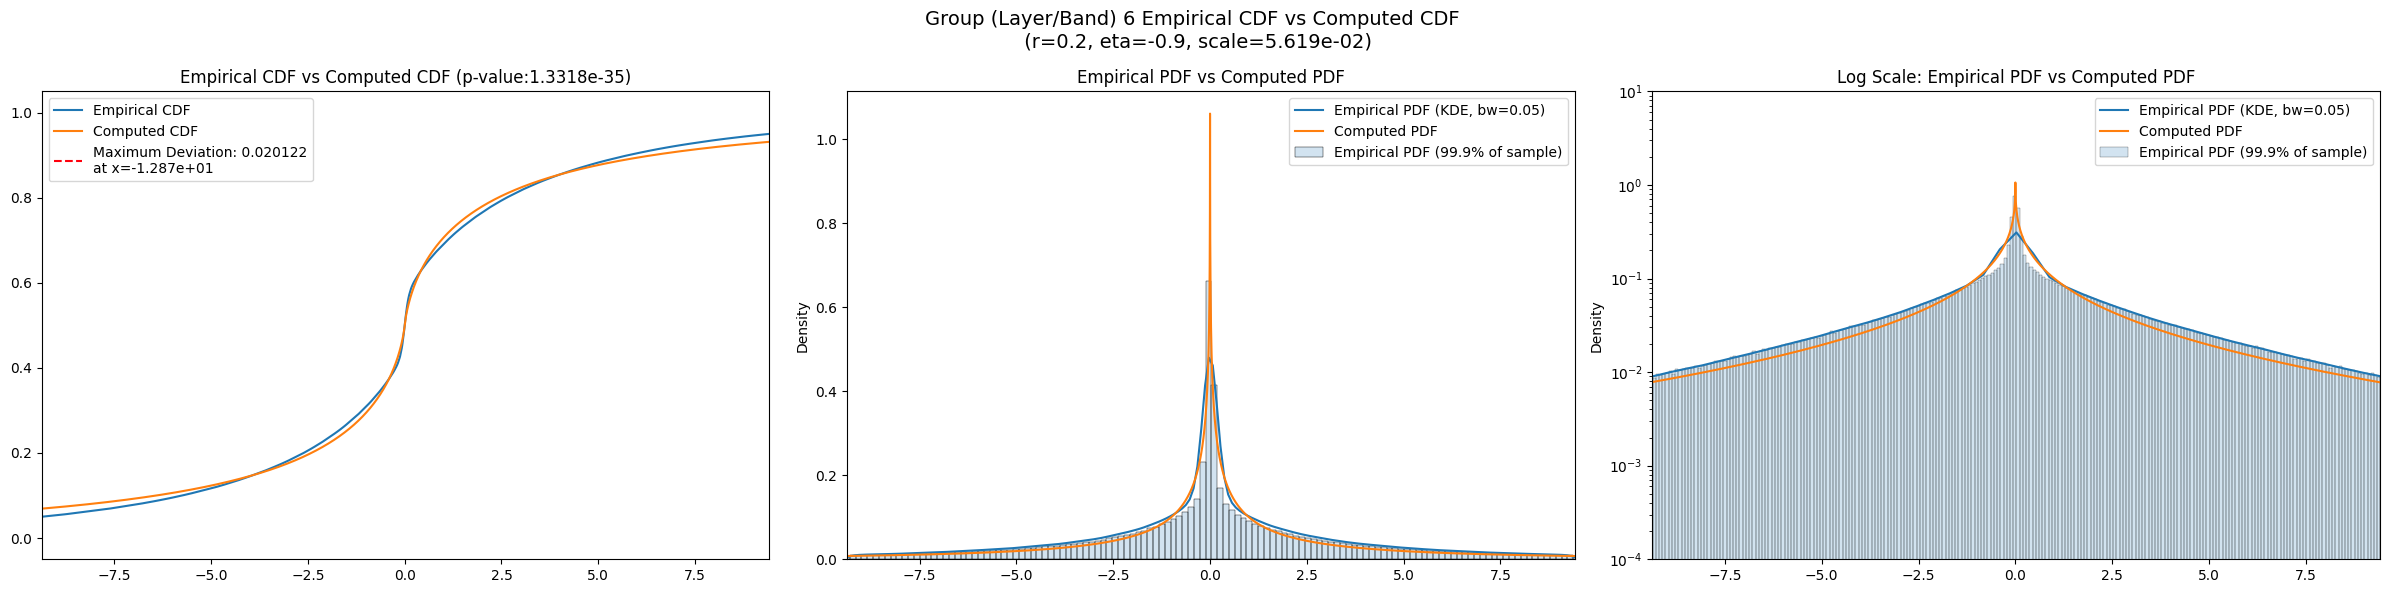

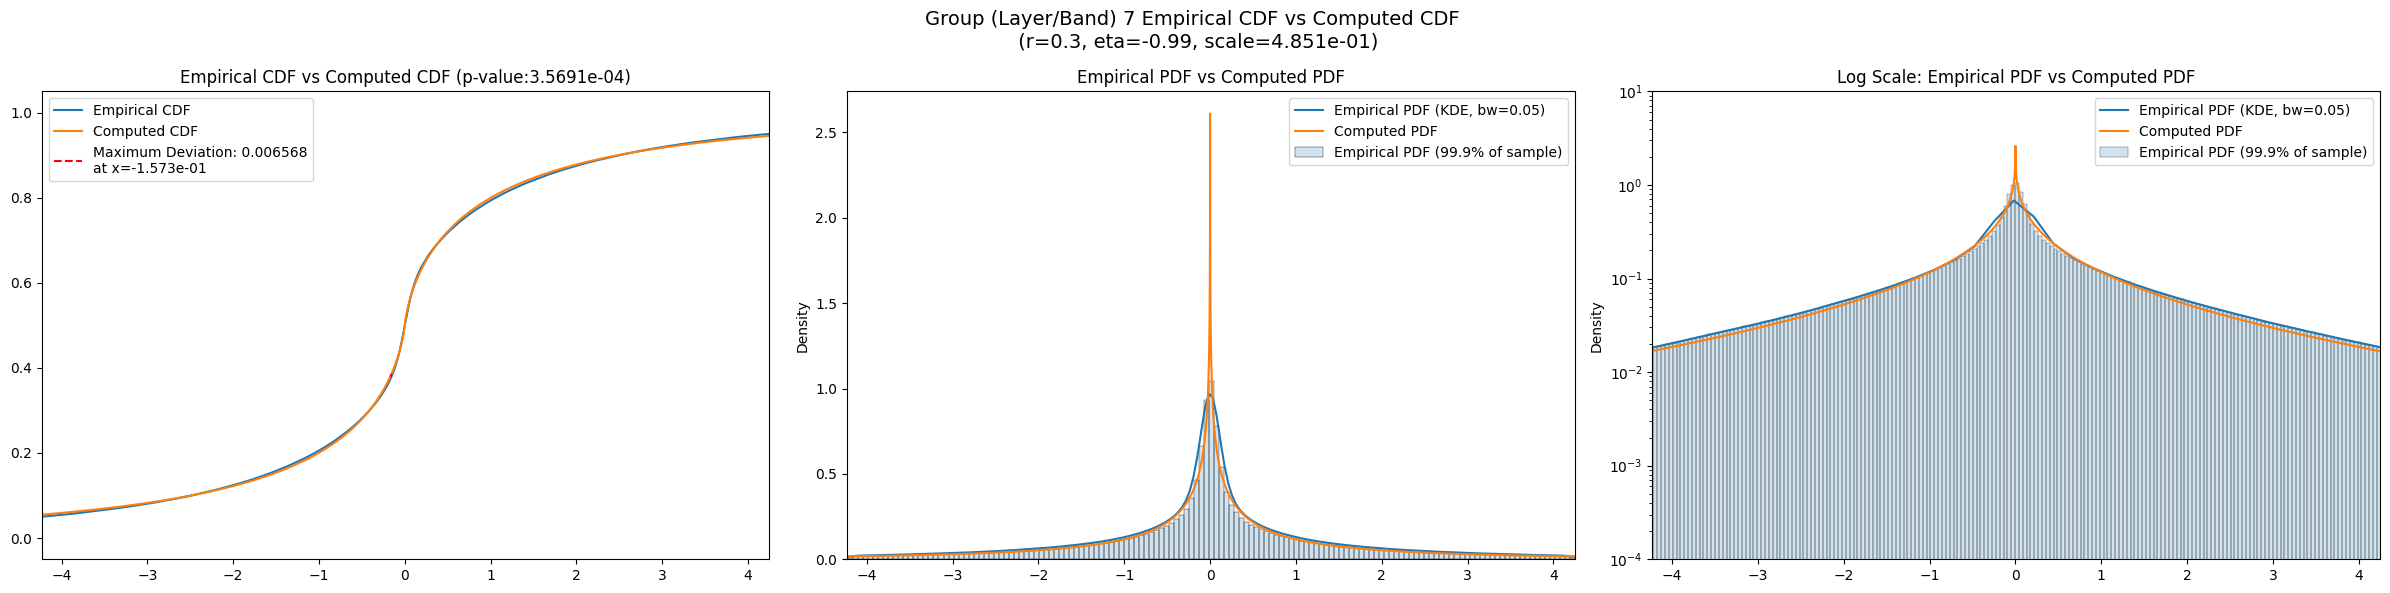

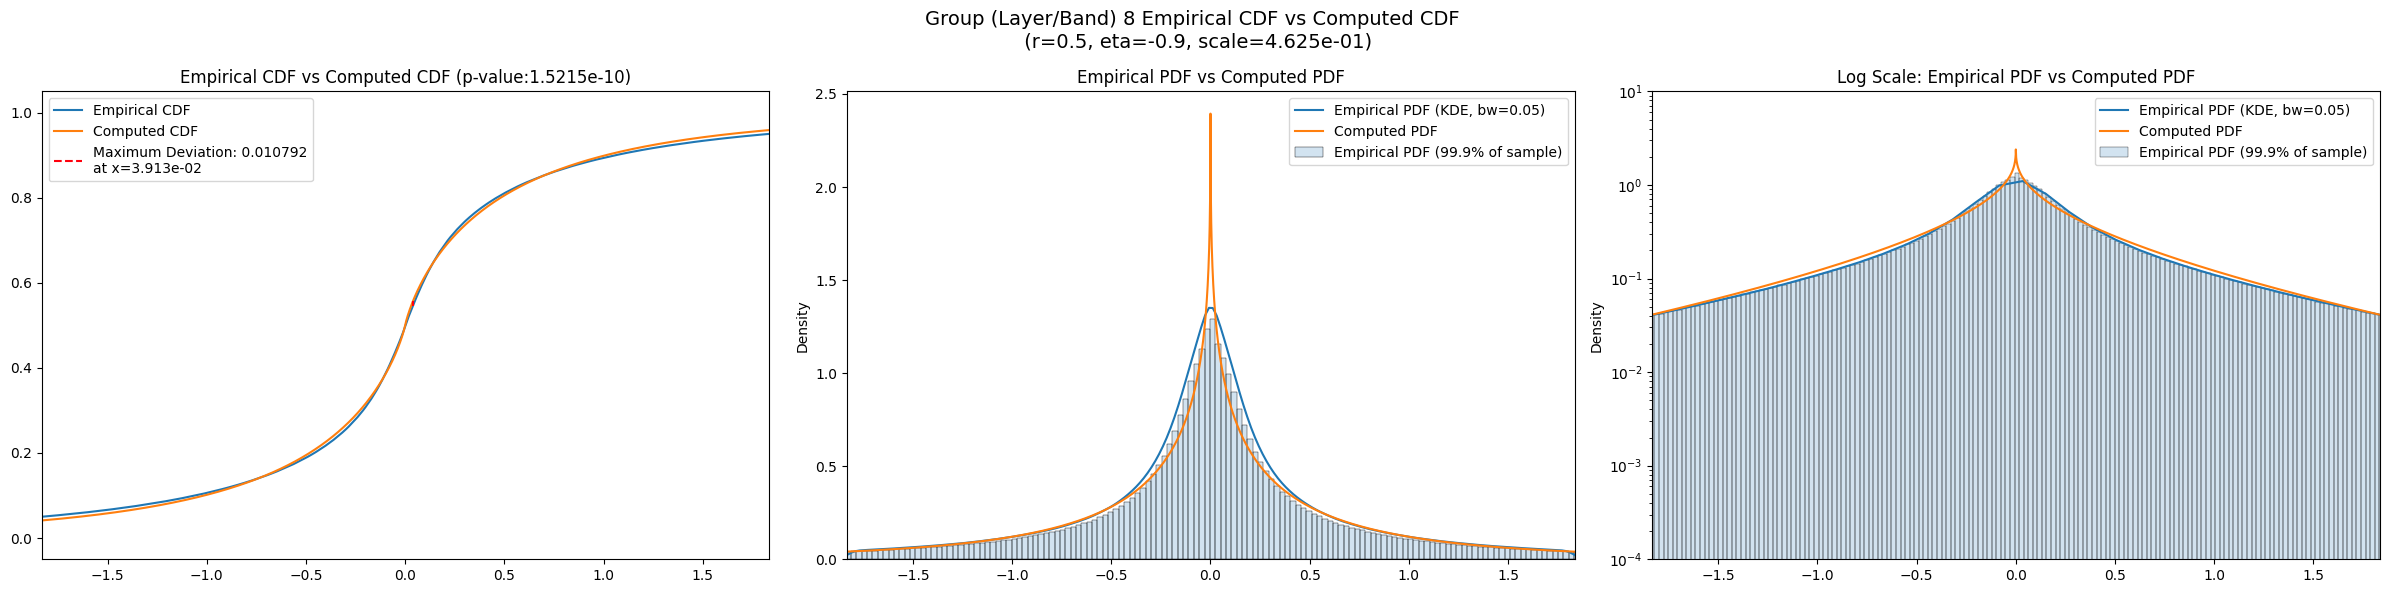

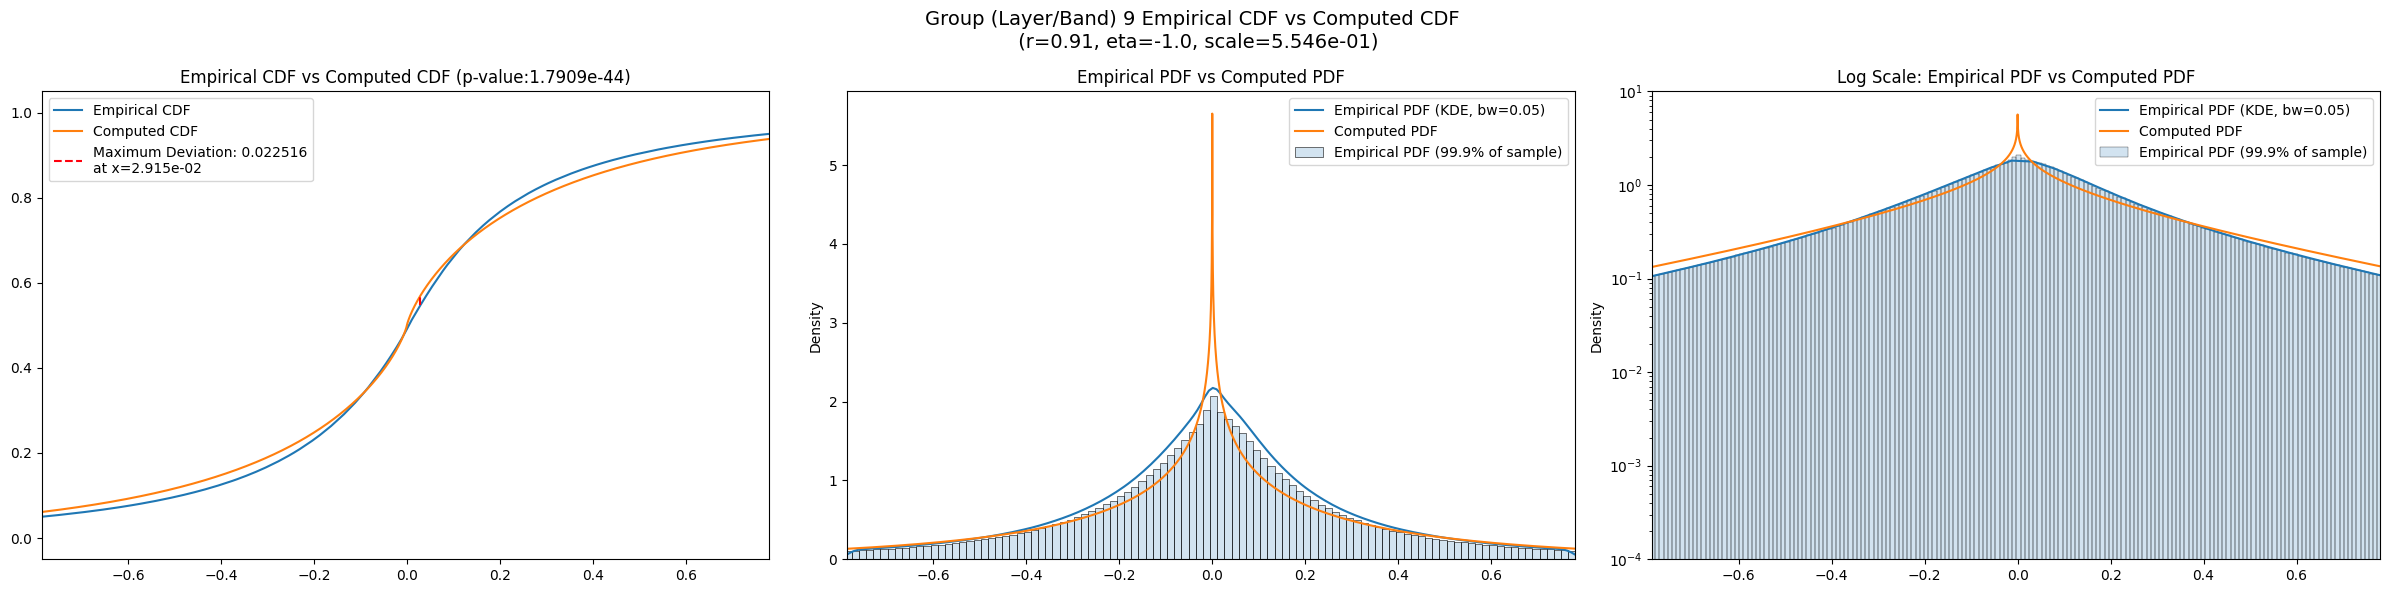

In [15]:
for group in GROUPS:
    group_info = master_df.loc[group]
    best_r = group_info['best_r']
    best_eta = group_info['best_eta']
    best_scale = group_info['best_scale']
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (best_r, best_eta, best_scale), 
                    log_scale = True,
                    group = group)
    #fig.savefig(os.path.join(CWD, "plots", f'compare_cdf_pdf_layer_{group}.jpg'), bbox_inches = 'tight', dpi = 100)

## Comparing with Gaussian and Laplace Priors

In [16]:
def generate_func(sample, distro, *args, n_samples=200):
    if distro == 'gaussian' or distro == 'normal':
        def var_func(var):
            cdf = scipy.stats.norm(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'laplace':
        def var_func(var):
            cdf = scipy.stats.laplace(scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 't':
        def var_func(var):
            cdf = scipy.stats.t(df=2, scale=var).cdf
            return compute_ksstat(sample, cdf)
        return var_func
    elif distro == 'prior_r':
        eta = args[0]
        def r_func(r):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return r_func
    elif distro == 'prior_eta':
        r = args[0]
        def eta_func(eta):
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples)
            return compute_ksstat(sample, cdf)
        return eta_func
    elif distro == 'prior':
        def r_eta_func(params):
            r = params[0]
            eta = params[1]
            cdf = compute_prior_cdf(r, eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample, cdf)
        return r_eta_func
    elif distro == 'prior_with_scale':
        def r_eta_scale_func(params):
            r = params[0]
            eta = params[1]
            scale = params[2]
            print(r, eta, scale)
            cdf = compute_prior_cdf(r = r, eta = eta, n_samples=n_samples, debug=False)
            return compute_ksstat(sample/ np.sqrt(scale), cdf)
        return r_eta_scale_func

    print("Please enter a valid argument for `distro`: 'gaussian', 'laplace', 'prior_r', 'prior_eta', 'prior','prior_with_scale', 't'")

In [17]:
master_df_path = Path(os.path.join(CWD, "CSVs", 'master_df.csv'))

if RERUN or not master_df_path.exists():
    upper_bound = int(1e6)
    for group in GROUPS:
        if len(group_data_map[group]) == 0:
            continue
        norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, upper_bound))
        laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, upper_bound))
        t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, upper_bound))
        
        master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
        master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

        master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
        master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

        master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
        master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
        master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

        master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(master_df.loc[group, 'kstest_stat_best']))

    #master_df.to_csv(os.path.join(CWD, "CSVs", 'master_df.csv'))
    
#master_df = pd.read_csv(os.path.join(CWD, "CSVs", 'master_df.csv'), index_col = GROUP)
master_df

obs_var    var_lower     var_upper    obs_kurt  kurt_lower  \
layer                                                                   
2      9382.064453  8727.582031  10077.744141    5.738890    3.878658   
3      1374.690918  1242.118530   1524.680054   14.064596    9.466524   
4       583.372559   530.836365    640.124695   11.037436    8.035024   
5       161.018326   147.046570    175.983200   10.230708    7.579123   
6        39.273979    35.769203     43.227554   11.540079    7.643221   
7         9.062507     8.068499     10.313087   20.645525   11.093557   
8         1.967857     1.680876      2.520643   60.267502   15.181164   
9         0.349839     0.287847      0.558240  220.299255   12.184872   

       kurt_upper  total_samples  kstest_stat_initial  initial_r  initial_eta  \
layer                                                                           
2        8.221848          13604             0.020056        0.2          0.3   
3       23.382521          54416             0.221938        8.0         -0.9   
4       17.098072         166649             0.133100        0.2         -0.9   
5       14.656498         574769             0.074440        0.2         -0.9   
6       22.754463        2125625             0.020122        0.2         -0.9   
7       57.528484        8502500             0.012600        0.3         -1.0   
8      273.336731       34010000             0.010792        0.5         -0.9   
9      840.170227      136040000             0.025280        0.7         -1.0   

       ...  param_gaussian  kstest_stat_gaussian  kstest_pval_gaussian  \
layer  ...                                                               
2      ...       69.182300              0.040674          5.417730e-20   
3      ...        2.031020              0.221938          0.000000e+00   
4      ...        5.798840              0.147211          0.000000e+00   
5      ...        4.336820              0.111911          0.000000e+00   
6      ...        3.015030              0.072796          0.000000e+00   
7      ...        1.248390              0.077870          0.000000e+00   
8      ...        0.609114              0.063697          0.000000e+00   
9      ...        0.321221              0.046302          0.000000e+00   

       param_laplace  kstest_stat_laplace  kstest_pval_laplace    param_t  \
layer                                                                       
2          57.392400             0.022842             0.000001  48.182900   
3           1.399740             0.221938             0.000000   1.406840   
4           4.297810             0.137241             0.000000   3.321520   
5           3.307200             0.099957             0.000000   2.645270   
6           2.419870             0.054756             0.000000   1.942160   
7           1.056080             0.053685             0.000000   0.832192   
8           0.535352             0.036551             0.000000   0.423502   
9           0.283293             0.019327             0.000000   0.223177   

       kstest_stat_t  kstest_pval_t  kstest_pval_gengamma  
layer                                                      
2           0.027326   2.941600e-09              0.000035  
3           0.221938   0.000000e+00              0.000000  
4           0.138626   0.000000e+00              0.000000  
5           0.102571   0.000000e+00              0.000000  
6           0.058314   0.000000e+00              0.000000  
7           0.056378   0.000000e+00                   NaN  
8           0.035913   0.000000e+00              0.000000  
9           0.019601   0.000000e+00              0.000000  

[8 rows x 30 columns]

## Results

In [18]:
import pandas as pd
import os
#master_df = pd.read_csv(os.path.join(os.getcwd(), "CSVs", 'master_df.csv'), index_col = 0)

In [19]:
master_df.filter(regex="kstest_stat.*")

kstest_stat_initial  kstest_stat_cutoff_0.05  kstest_stat_best  \
layer                                                                   
2                 0.020056                 0.011632          0.020056   
3                 0.221938                 0.005819          0.221938   
4                 0.133100                 0.003326          0.133100   
5                 0.074440                 0.001791          0.074440   
6                 0.020122                 0.000931          0.020122   
7                 0.012600                 0.000466          0.006568   
8                 0.010792                 0.000233          0.010792   
9                 0.025280                 0.000116          0.022516   

       kstest_stat_gaussian  kstest_stat_laplace  kstest_stat_t  
layer                                                            
2                  0.040674             0.022842       0.027326  
3                  0.221938             0.221938       0.221938  
4                  0.147211             0.137241       0.138626  
5                  0.111911             0.099957       0.102571  
6                  0.072796             0.054756       0.058314  
7                  0.077870             0.053685       0.056378  
8                  0.063697             0.036551       0.035913  
9                  0.046302             0.019327       0.019601

In [20]:
master_df.filter(regex="best.*")

best_augmented_var  kstest_stat_best  best_r  best_eta  best_scale  \
layer                                                                       
2             7381.472168          0.020056    0.20      0.30    0.090683   
3             1374.690918          0.221938    8.00     -0.90    6.956222   
4              583.372559          0.133100    0.20     -0.90    0.100210   
5              161.018326          0.074440    0.20     -0.90    0.092886   
6               35.195274          0.020122    0.20     -0.90    0.056194   
7                9.062507          0.006568    0.30     -0.99    0.485066   
8                1.197001          0.010792    0.50     -0.90    0.462484   
9                0.204721          0.022516    0.91     -1.00    0.554640   

       best_exclude_cutoff  
layer                       
2                     75.0  
3                      0.0  
4                      0.0  
5                      0.0  
6                    100.0  
7                      0.0  
8                    500.0  
9                    600.0

In [21]:
eng.quit()